# TFG. Detección de anomalías en contaminación del aire. 
#### Lucía Carro Arcaya

## Carga de librerías

In [11]:
import os
import json
import math
import folium
import calendar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Carga de datos preprocesados

In [12]:
datos_d_global = pd.read_csv("datos_procesados/datos_d_global.csv", index_col=0, parse_dates=True)
datos_h_global = pd.read_csv("datos_procesados/datos_h_global.csv", index_col=0, parse_dates=True)
datos_d_estacion = pd.read_csv("datos_procesados/datos_d_estacion.csv", index_col=0, parse_dates=True)
datos_h_estacion = pd.read_csv("datos_procesados/datos_h_estacion.csv", index_col=0, parse_dates=True)
datos_index = pd.read_csv("datos_procesados/datos_index.csv", index_col=0, parse_dates=True)
localizaciones = pd.read_csv("datos_procesados/localizaciones.csv", index_col=0, parse_dates=True)

C:\Users\Lucia\AppData\Local\Temp\ipykernel_21068\659314484.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datos_d_estacion = pd.read_csv("datos_procesados/datos_d_estacion.csv", index_col=0, parse_dates=True)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_21068\659314484.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datos_h_estacion = pd.read_csv("datos_procesados/datos_h_estacion.csv", index_col=0, parse_dates=True)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_21068\659314484.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  localizaciones = pd.read_csv("datos_pr

## Estadísticas descriptivas

### Diferencia entre Value y ValueOrigin

In [13]:
def comparar_value_vs_origin(df, nombre_salida="global"):
    value_pairs = []
    for col in df.columns:
        if col.endswith("Value"):
            origin_col = col.replace("Value", "ValueOrigin")
            if origin_col in df.columns:
                value_pairs.append((col, origin_col))

    comparacion_value_origin = []

    for val_col, origin_col in value_pairs:
        val_series = df[val_col]
        origin_series = df[origin_col]

        diff_abs = (val_series - origin_series).abs()
        diff_pct = 100 * diff_abs / val_series.replace(0, pd.NA).abs()

        resumen = {
            "Variable": val_col.replace("Value", ""),
            "Media Value": round(val_series.mean(skipna=True), 2),
            "Media ValueOrigin": round(origin_series.mean(skipna=True), 2),
            "Diferencia absoluta media": round(diff_abs.mean(skipna=True), 3),
            "Diferencia relativa media (%)": round(diff_pct.mean(skipna=True), 3),
            "Número de valores comparados": diff_abs.count()
        }

        comparacion_value_origin.append(resumen)

    df_vo_summary = pd.DataFrame(comparacion_value_origin).sort_values("Diferencia relativa media (%)", ascending=False)

    print(df_vo_summary.to_string(index=False))

In [14]:
print("Diferencia Value VS ValueOrigin para datos diarios")
comparar_value_vs_origin(datos_d_global, "diario")
print("\nDiferencia Value VS ValueOrigin para datos horarios")
comparar_value_vs_origin(datos_h_global, "horario")


Diferencia Value VS ValueOrigin para datos diarios
Variable  Media Value  Media ValueOrigin  Diferencia absoluta media  Diferencia relativa media (%)  Número de valores comparados
     SO2         2.85               2.83                      0.036                          1.330                           879
     PM1         7.57               7.53                      0.050                          1.207                           558
    PM25        11.50              11.46                      0.042                          0.514                           879
    PM10        23.10              23.05                      0.048                          0.233                           879
      NO        10.81              10.81                      0.007                          0.124                           561
     NO2        19.93              19.93                      0.003                          0.021                           879
     NOX        34.55              34.55      

Se compararon las columnas Value y ValueOrigin en los datos diarios y horarios. En todos los casos, las diferencias absolutas y relativas fueron inferiores al 3%, siendo en su mayoría cercanas o iguales a cero. Dado que ValueOrigin no aporta diferencias relevantes ni mejora la calidad del dato, se optó por trabajar exclusivamente con las columnas Value para simplificar el conjunto de datos sin comprometer la validez del análisis.

In [15]:
# Eliminar columnas ValueOrigin en todos los datasets
for df_name in ["datos_d_global", "datos_h_global","datos_d_estacion", "datos_h_estacion", "datos_index"]:
    globals()[df_name] = globals()[df_name].drop(
        columns=[col for col in globals()[df_name].columns if col.endswith("ValueOrigin")]
    )

In [16]:
# Guardar los archivos modificados sin ValueOrigin
datos_d_global.to_csv("datos_procesados/datos_d_global.csv", index=True)
datos_h_global.to_csv("datos_procesados/datos_h_global.csv", index=True)
datos_d_estacion.to_csv("datos_procesados/datos_d_estacion.csv", index=True)
datos_h_estacion.to_csv("datos_procesados/datos_h_estacion.csv", index=True)
datos_index.to_csv("datos_procesados/datos_index.csv", index=True)

### Diferencias entre datos horarios y diarios. 

In [17]:
os.makedirs("estadisticas_descriptivas", exist_ok=True)
resumen_d_global = datos_d_global.describe().T
resumen_h_global = datos_h_global.describe().T

# Comparar medias y desviaciones estándar entre datos diarios y horarios
comparacion = resumen_d_global[['mean', 'std']].join(
    resumen_h_global[['mean', 'std']],
    lsuffix='_diario',
    rsuffix='_horario'
)

# Calcular diferencias relativas en porcentaje
comparacion["Diferencia media (%)"] = 100 * (comparacion["mean_horario"] - comparacion["mean_diario"]) / comparacion["mean_diario"]
comparacion["Diferencia std (%)"] = 100 * (comparacion["std_horario"] - comparacion["std_diario"]) / comparacion["std_diario"]

# Redondear para presentación
comparacion = comparacion.round(2)

# Ordenar por mayor diferencia en media
comparacion_ordenada = comparacion.sort_values("Diferencia media (%)", ascending=False)
print(comparacion_ordenada.to_string())

           mean_diario  std_diario  mean_horario  std_horario  Diferencia media (%)  Diferencia std (%)
PM1Value          7.57        5.72          7.59         7.26                  0.16               26.91
NO2Value         19.93        9.46         19.96        13.81                  0.12               45.91
SO2Value          2.85        0.71          2.86         0.94                  0.07               33.13
PM25Value        11.50        7.11         11.51         9.27                  0.06               30.44
PM10Value        23.10        9.46         23.11        13.40                  0.04               41.63
NOValue          10.81       10.75         10.81        18.31                 -0.06               70.28
O3Value          53.03       17.81         52.98        26.19                 -0.09               47.05
NOXValue         34.55       18.97         34.52        28.38                 -0.11               49.60


Se compararon estadísticas descriptivas entre los datos horarios y diarios. Las medias fueron prácticamente iguales en todas las variables (<0.2% de diferencia), mientras que la desviación estándar fue sustancialmente mayor en los datos horarios. Esto es esperable debido a la variabilidad intra-diaria que se suaviza al calcular medias diarias. Dado que el análisis posterior se centra en tendencias y patrones diarios, se optó por utilizar exclusivamente los datos diarios, que son más estables y fáciles de manejar computacionalmente.

La comparación entre datos horarios y diarios se realizó a nivel global, demostrando que las medias eran prácticamente iguales (<0.2%) y que la desviación estándar era naturalmente mayor en la resolución horaria, debido a la variabilidad intra-diaria. Este mismo comportamiento se espera en los datos por estación, ya que se derivan del mismo conjunto original. Por tanto, se consideró innecesario repetir la comparación para cada estación individual.

### Valores nulos por variable

In [18]:
def analizar_valores_nulos(df, columnas=None):
    df_eval = df[columnas] if columnas else df
    total_filas = len(df_eval)

    # Cálculo de nulos
    nulos = df_eval.isna().sum()
    nulos = nulos[nulos > 0].sort_values(ascending=False)

    # Cálculo de porcentaje
    porcentaje_nulos = (nulos / total_filas * 100).round(2)
    tabla_nulos = pd.DataFrame({
        "Nulos": nulos,
        "% del total": porcentaje_nulos
    })

    print(tabla_nulos.to_string())

In [19]:
print("Para datos diarios globales")
analizar_valores_nulos(datos_d_global)

print("\nPara datos por estación")
columnas_valores = [col for col in datos_d_estacion.columns if col.endswith("Value")]
analizar_valores_nulos(datos_d_estacion, columnas=columnas_valores)


Para datos diarios globales
          Nulos  % del total
PM1Value    321        36.52
NOValue     318        36.18
NOXValue    318        36.18

Para datos por estación
           Nulos  % del total
PM1Value    8433        88.31
NOValue     7442        77.93
NOXValue    7442        77.93
O3Value     4320        45.24
SO2Value    4320        45.24
PM10Value   1935        20.26
PM25Value   1935        20.26
NO2Value     210         2.20


Se realizó un análisis de valores nulos en los datos diarios globales y por estación. Algunas variables, como PM1Value, NOValue y NOXValue, presentaron más del 75% de valores ausentes, especialmente en el análisis por estación, lo que limita su utilidad para estudios temporales o de modelado. En cambio, NO2Value mostró una cobertura excelente (<3% de nulos), y PM10Value y PM25Value presentaron valores ausentes moderados (~20%). En base a estos resultados, se decidió enfocar el análisis principalmente en NO2, PM10 y PM25

### Boxplot

In [20]:
def mostrar_boxplots(df, estacion=False, variables=None, nombre="dataset"):
    # Detectar variables automáticamente si no se pasan
    if variables is None:
        variables = [col.replace("Value", "") for col in df.columns if col.endswith("Value")]

    if estacion:
        for var in variables:
            col = var + "Value"
            if col not in df.columns:
                continue

            plt.figure(figsize=(14, 6))
            sns.boxplot(x="entityId", y=col, data=df, showfliers=True)
            plt.xlabel("Estación")
            plt.ylabel("µg/m³")
            plt.title(f"Distribución de {var} por estación")
            plt.xticks(rotation=45, ha="right")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    else:
        # Boxplot conjunto de todas las variables numéricas seleccionadas
        columnas_val = [var + "Value" for var in variables if var + "Value" in df.columns]
        df_melted = df[columnas_val].melt(var_name="Variable", value_name="Valor")

        plt.figure(figsize=(14, 6))
        sns.boxplot(x="Variable", y="Valor", data=df_melted, showfliers=True)
        plt.title(f"Distribución global de variables ({nombre})")
        plt.ylabel("µg/m³")
        plt.xticks(rotation=45, ha="right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Gráfico global para todos los contaminantes


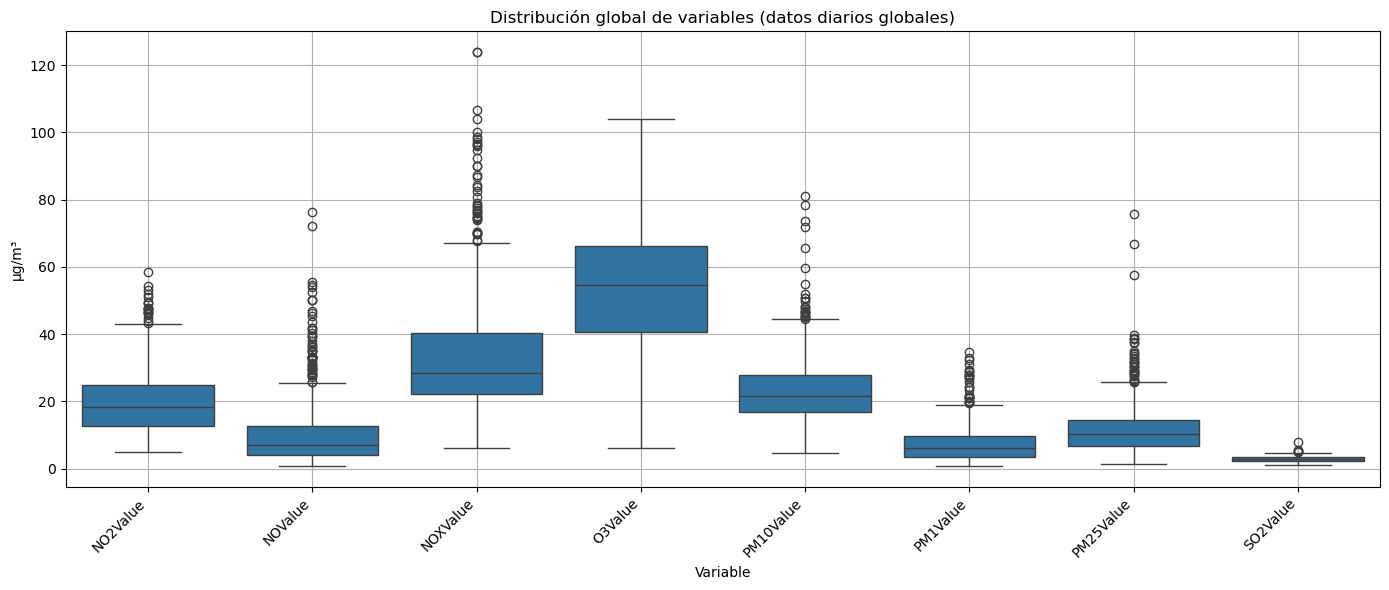

Gráficos individuales por contaminante


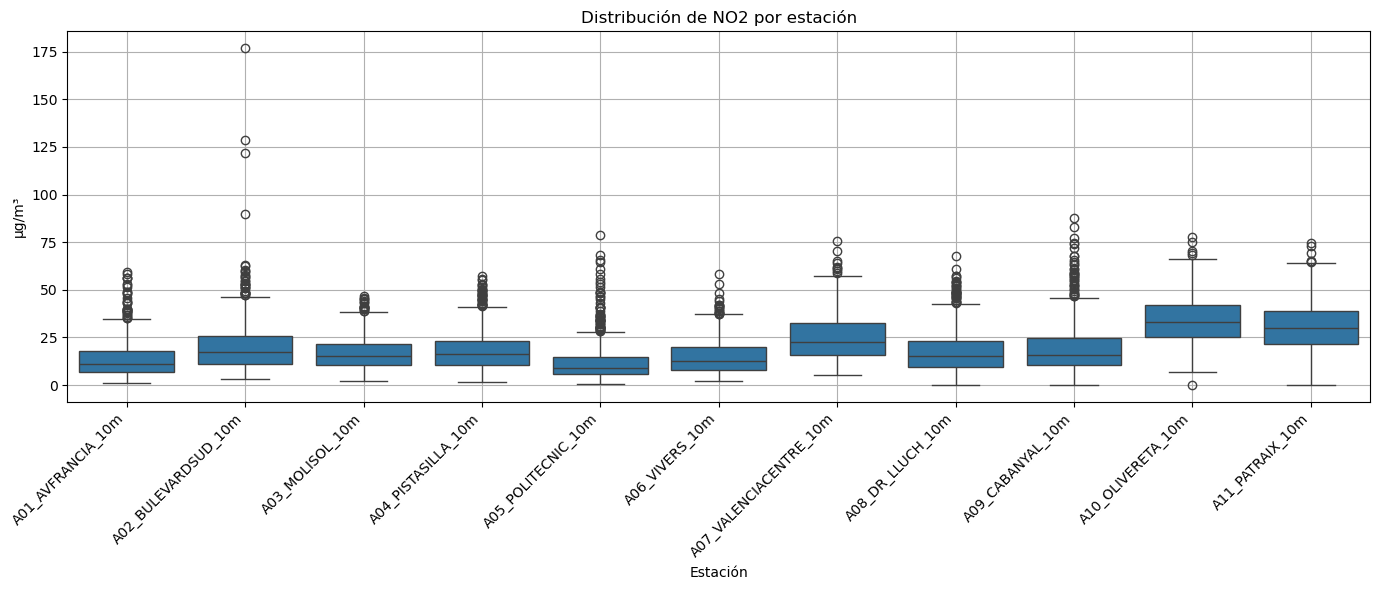

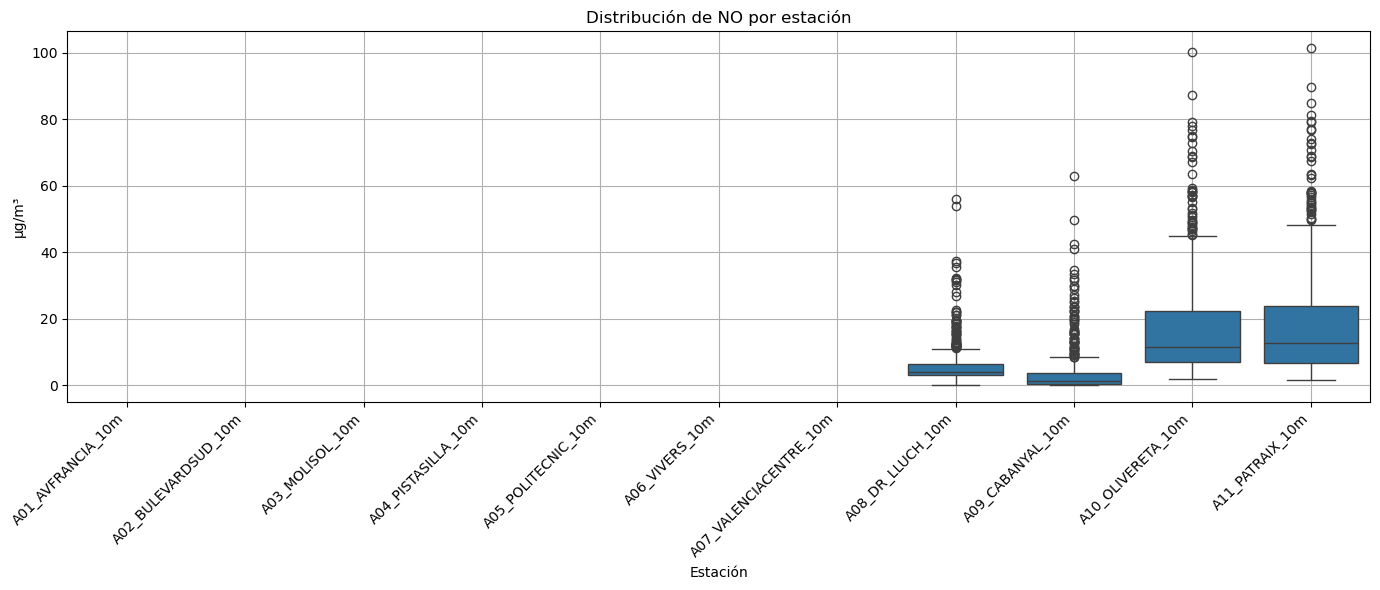

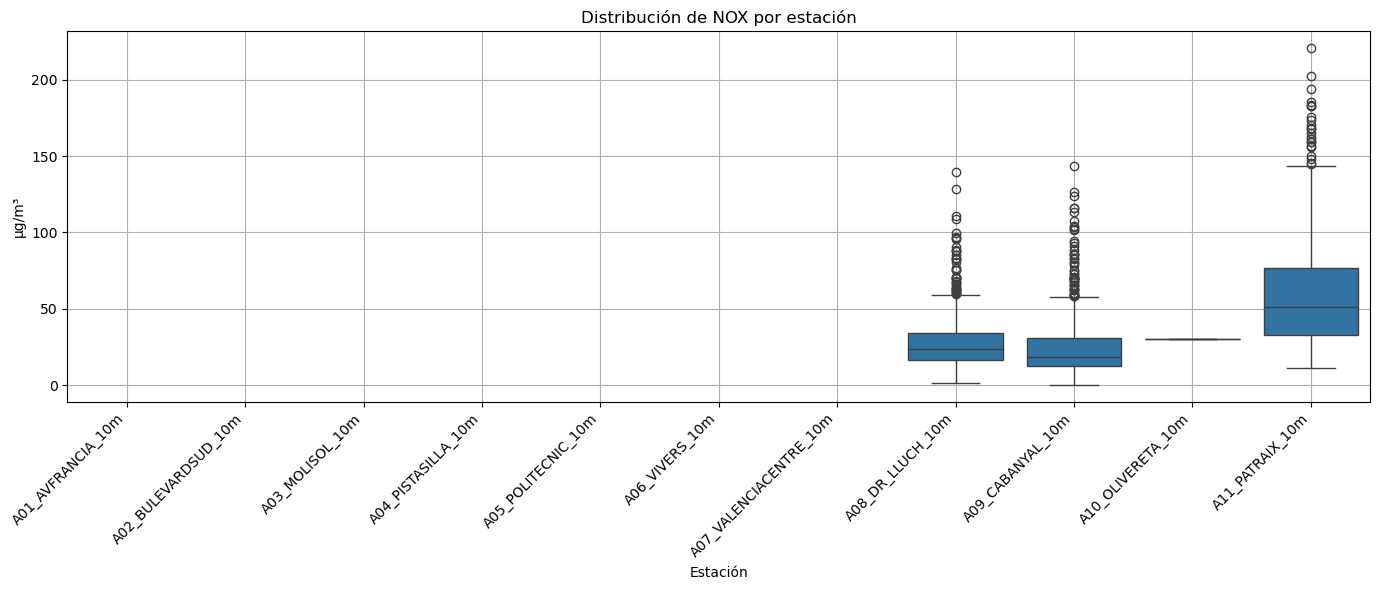

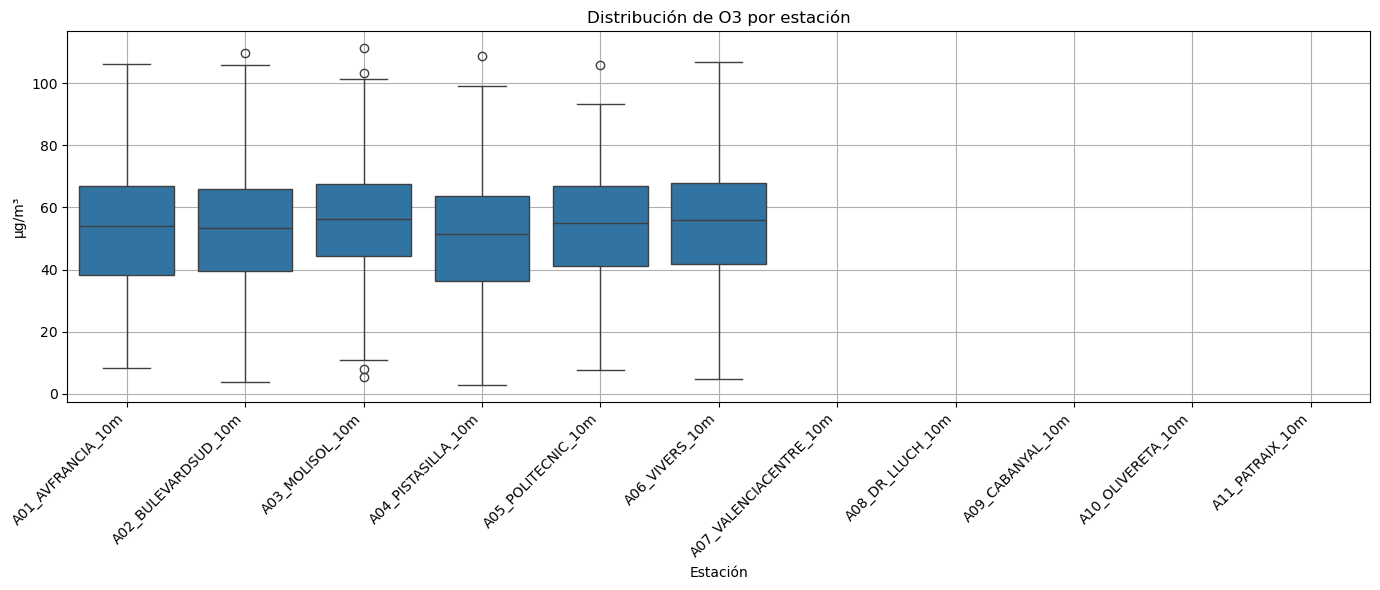

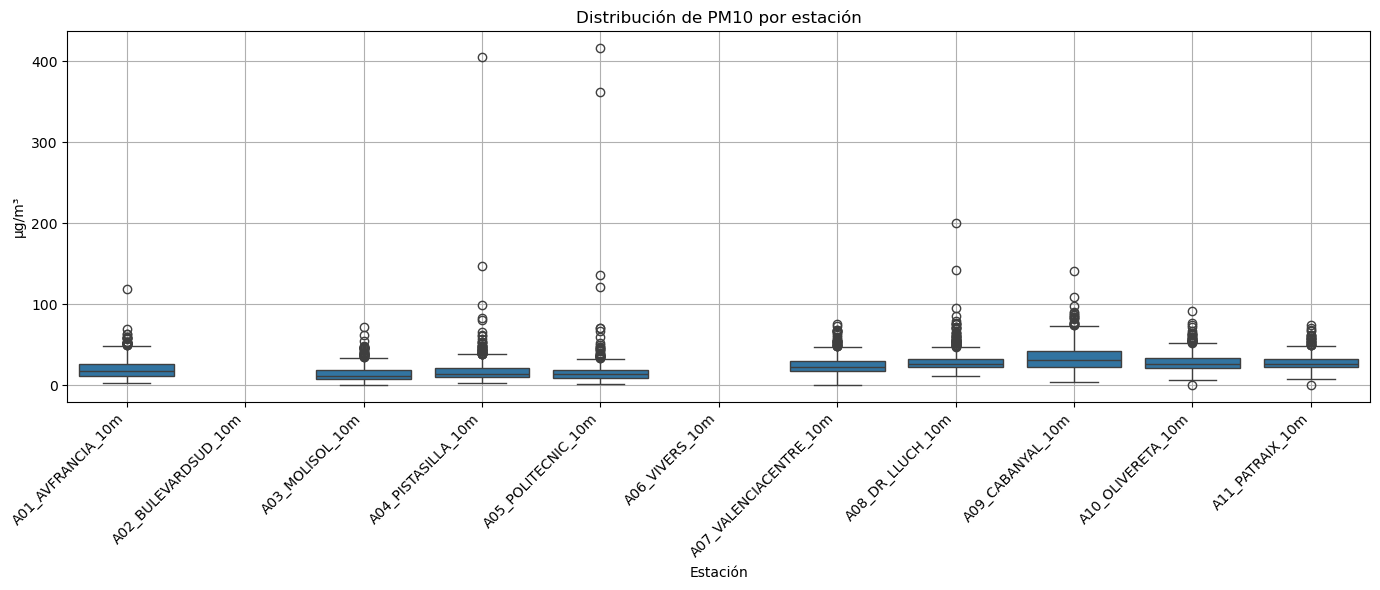

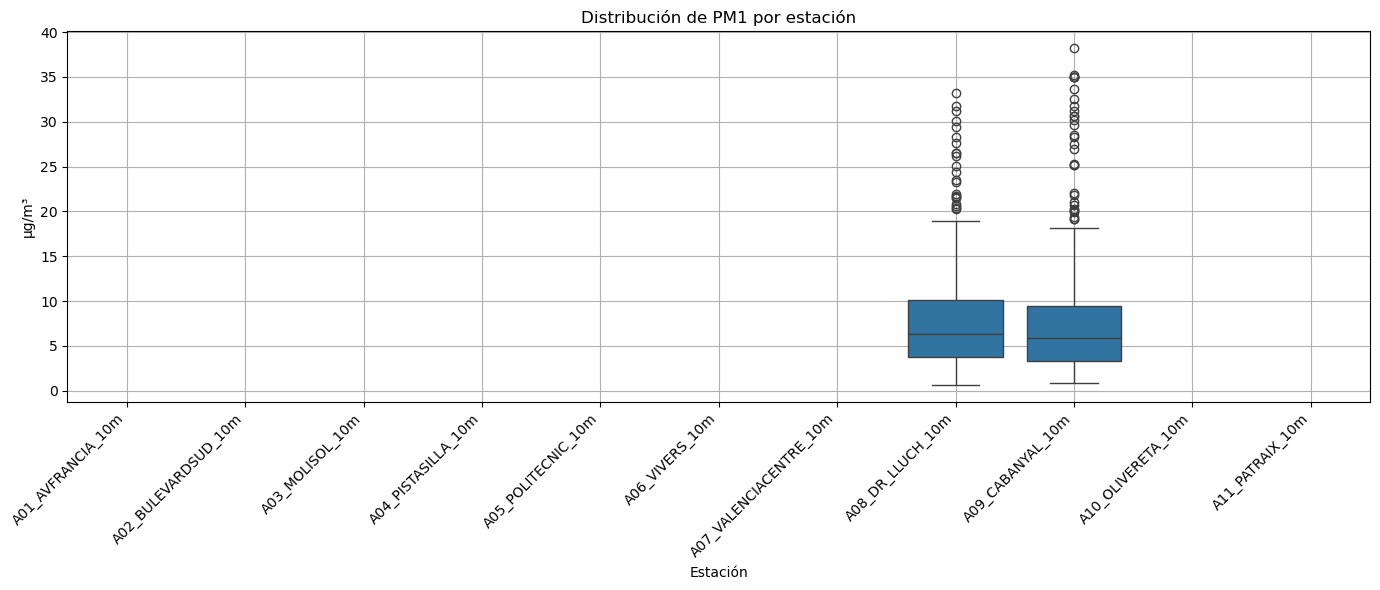

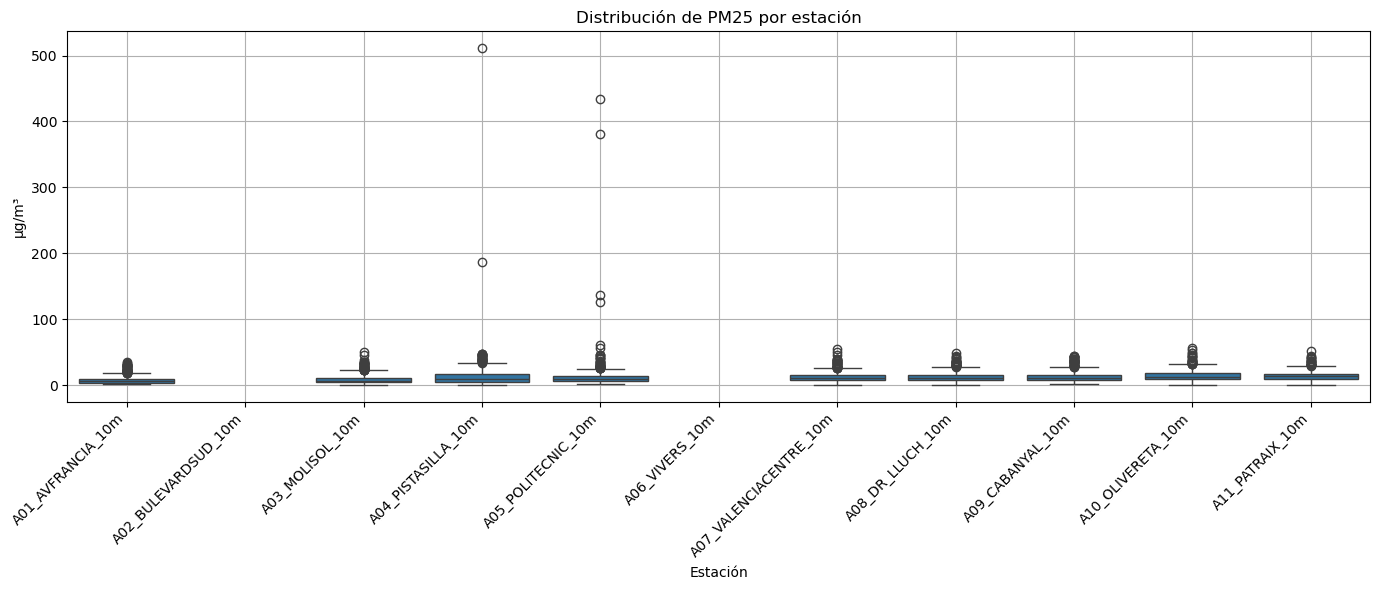

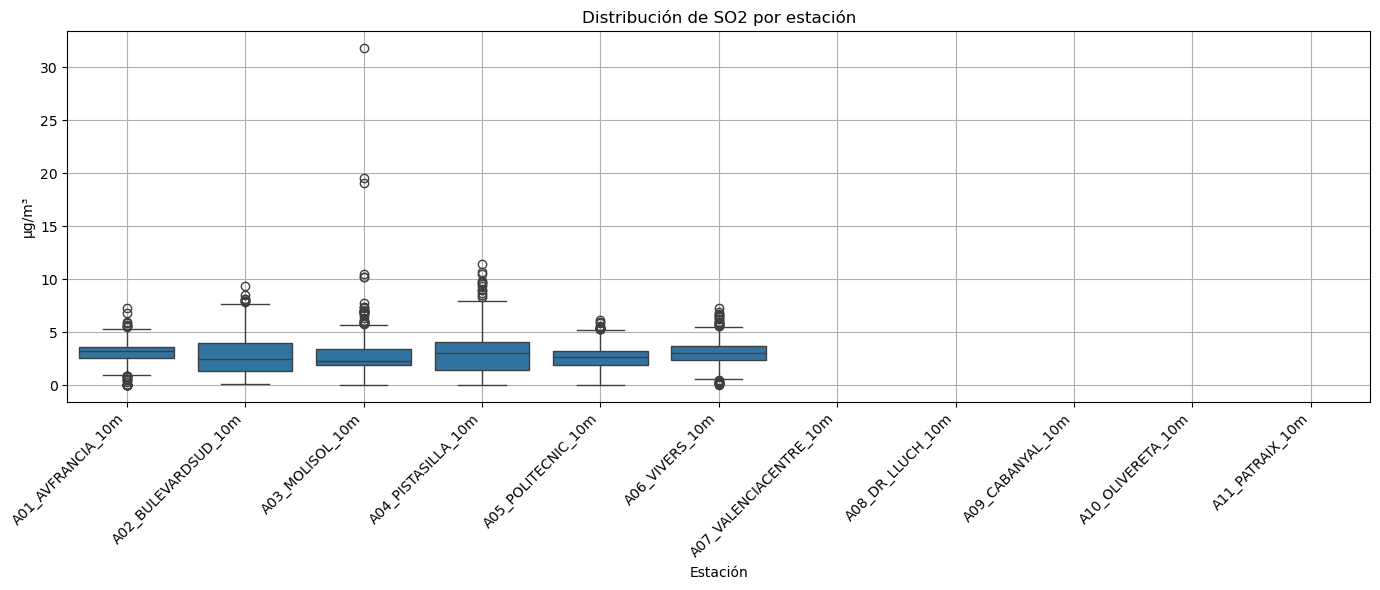

In [21]:
print("Gráfico global para todos los contaminantes")
mostrar_boxplots(datos_d_global, estacion=False, nombre="datos diarios globales")
print("Gráficos individuales por contaminante")
mostrar_boxplots(datos_d_estacion, estacion=True, nombre="datos diarios por estación")

Se utilizaron diagramas de caja para representar la distribución de cada contaminante tanto a nivel global como por estación. A nivel global, se observó que O3 y NOX presentaban mayor dispersión y número de outliers, indicando eventos puntuales extremos. El análisis por estación permitió identificar ubicaciones con concentraciones sistemáticamente más elevadas, como A11_PATRAIX_10m en NO2, o A04_PISTASILLA_10m en PM25. Esta información es clave para seleccionar variables y estaciones relevantes en el modelado posterior.

## Correlación

### Correlación entre contaminantes

**Correlación lineal**

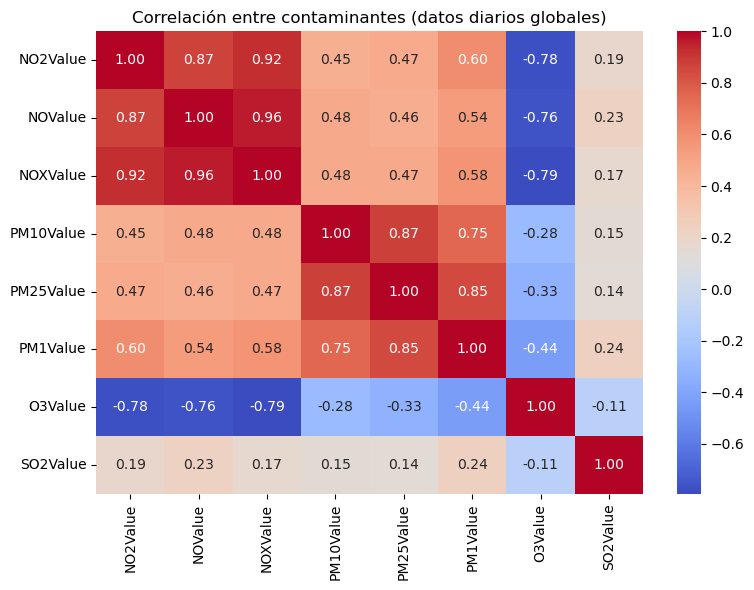

In [ ]:
contaminantes = ['NO2Value', 'NOValue', 'NOXValue', 'PM10Value', 'PM25Value', 'PM1Value','O3Value', 'SO2Value']
corr_matrix = datos_d_global[contaminantes].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre contaminantes (datos diarios globales)")
plt.tight_layout()
plt.show()

**Correlación multivariante**

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2378685302.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


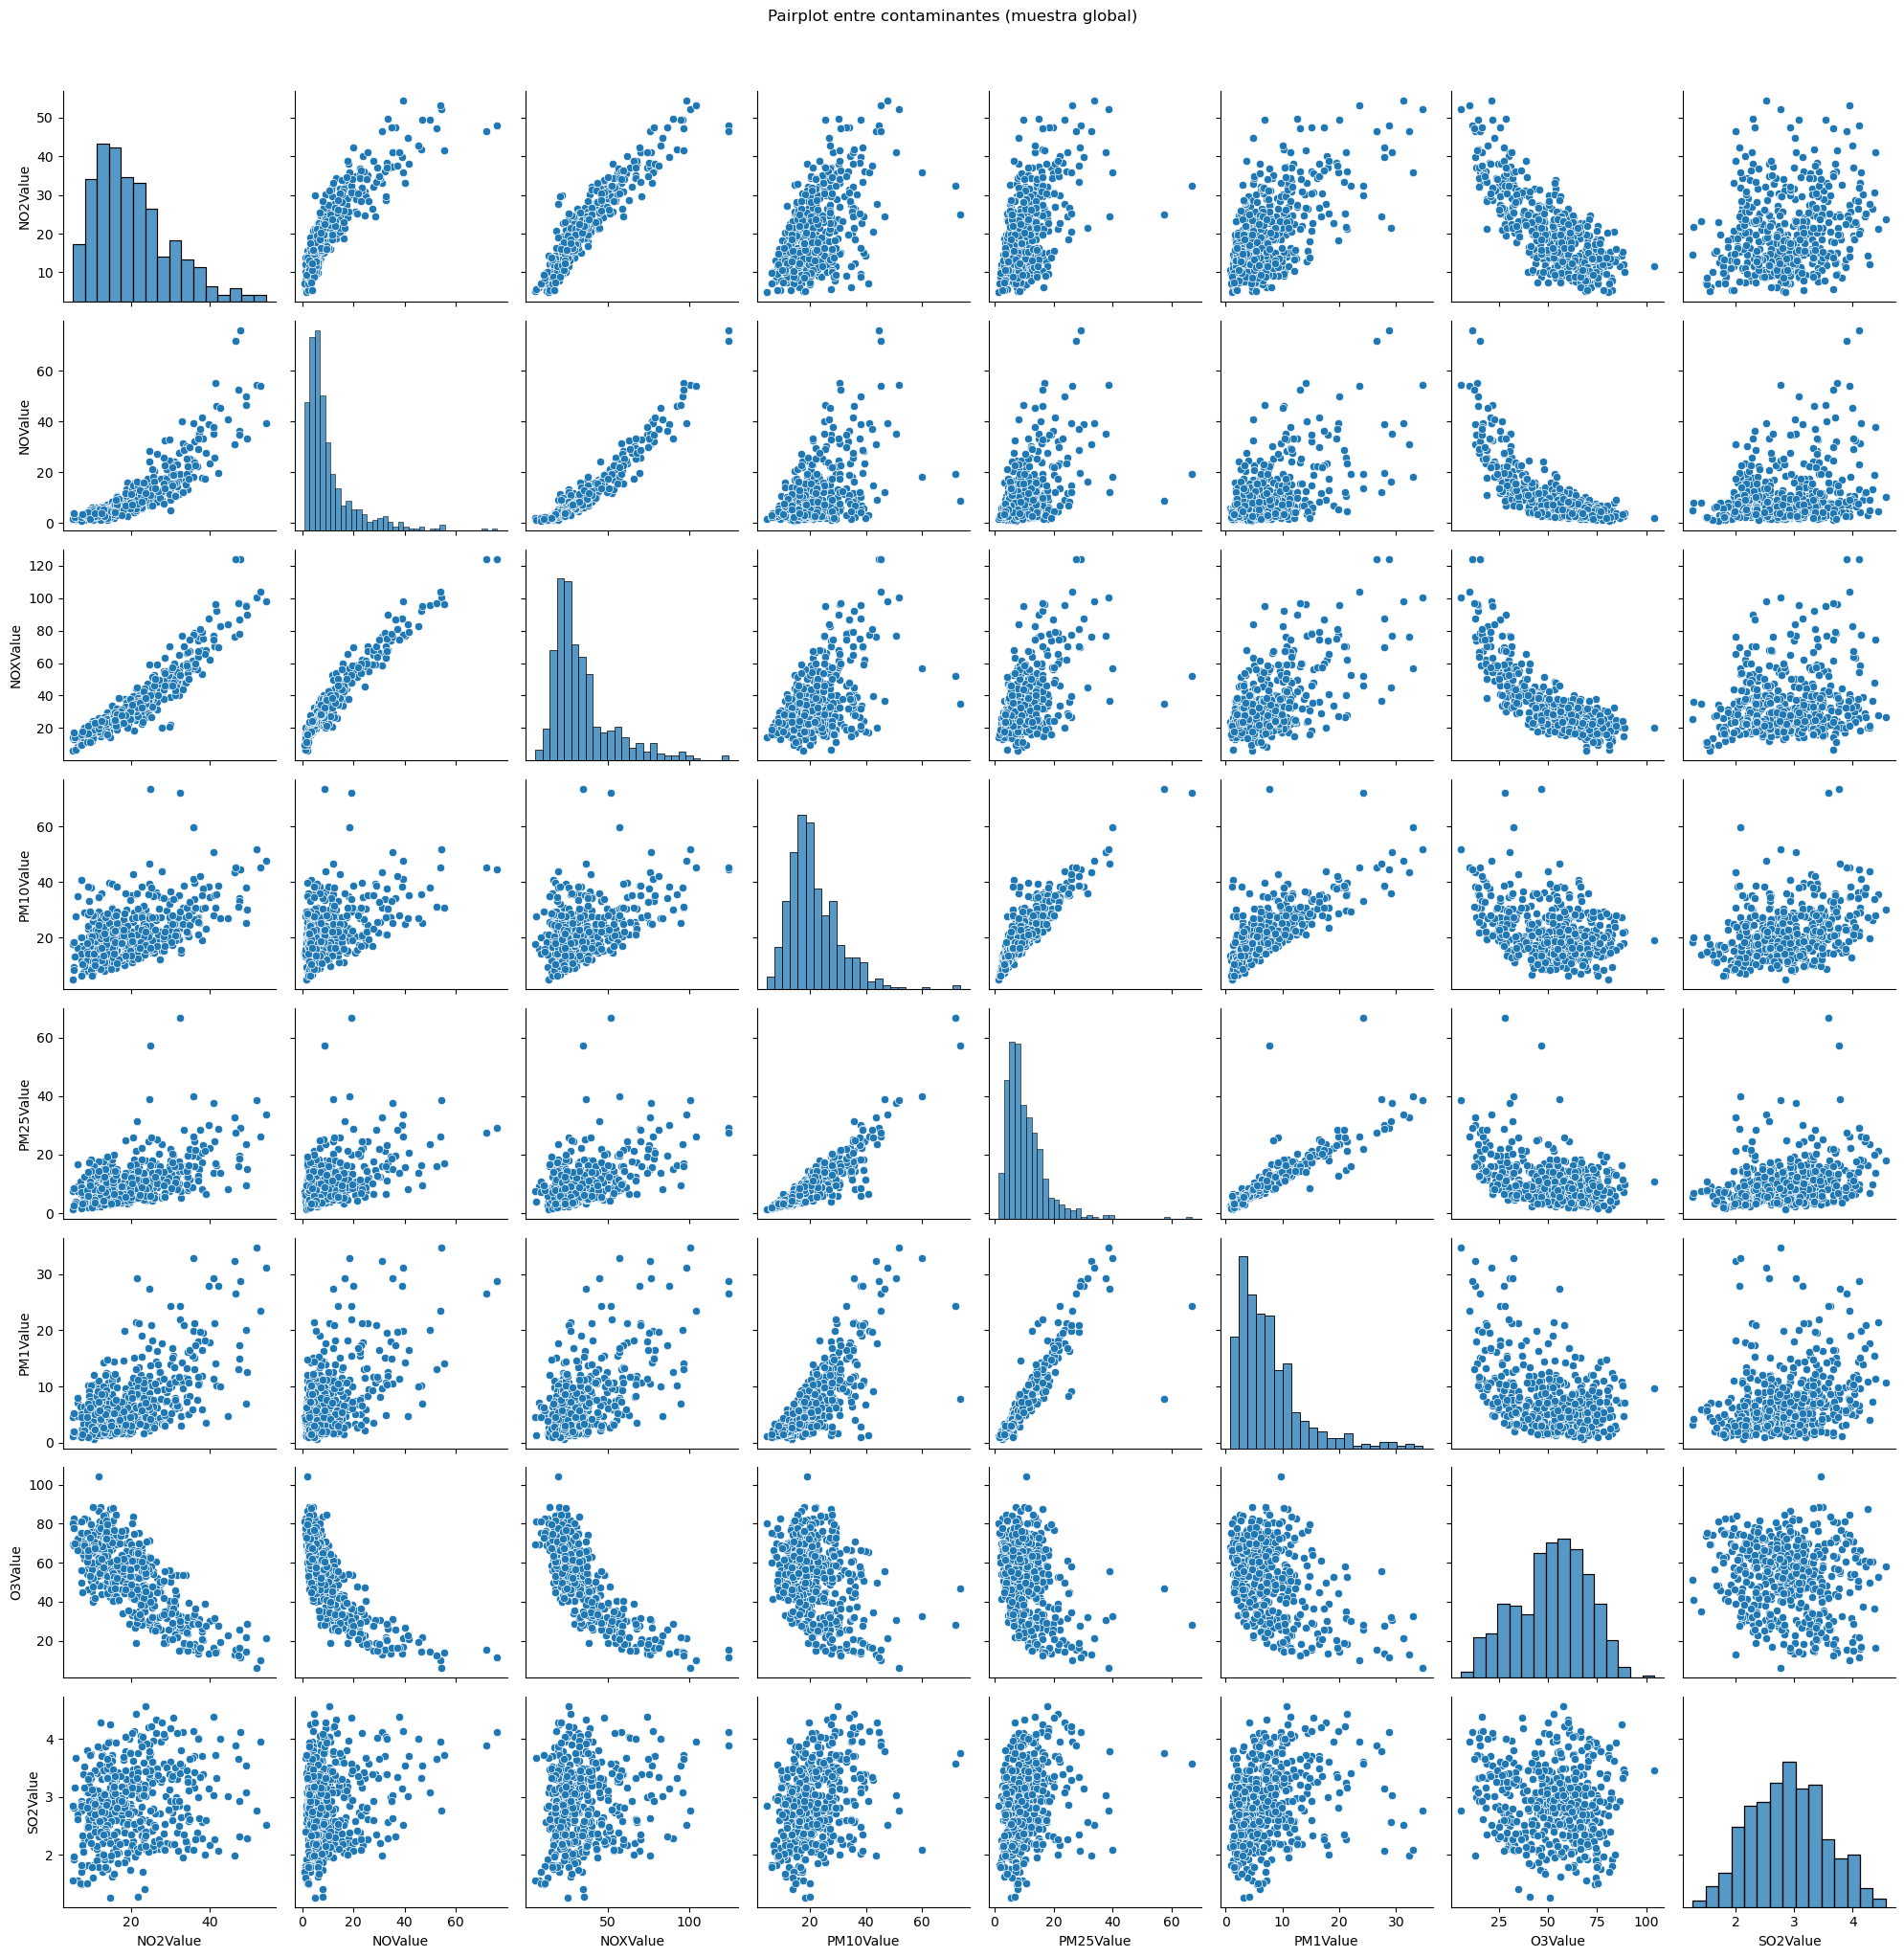

In [ ]:
# Reducimos el volumen de datos si es muy grande
df_sample = datos_d_global[contaminantes].dropna().sample(500)

# Pairplot con distribución y scatter por variable
sns.pairplot(df_sample)
plt.suptitle("Pairplot entre contaminantes (muestra global)", y=1.02)
plt.tight_layout()
plt.show()

Se realizó un análisis de correlación entre los principales contaminantes medidos en las estaciones de calidad del aire de Valencia, utilizando los datos diarios agregados a nivel global. Este análisis se abordó desde dos perspectivas: una matriz de correlación (heatmap) que resume cuantitativamente las relaciones lineales entre variables, y un gráfico de pares (pairplot) que permite visualizar la forma y dispersión de dichas relaciones.

En resumen, tras analizar las redundancias estadísticas, se seleccionan como variables clave para los análisis posteriores NO₂, PM₂.₅, O₃ y SO₂. Esta selección garantiza diversidad de orígenes, relevancia ambiental y reducción de multicolinealidad, aspectos todos esenciales para una modelización robusta de episodios de contaminación y detección de anomalías.

### Correlación entre contaminantes y estaciones

Antes de realizar el análisis de correlación entre contaminantes, se evaluó la cobertura de datos por estación y sustancia. 

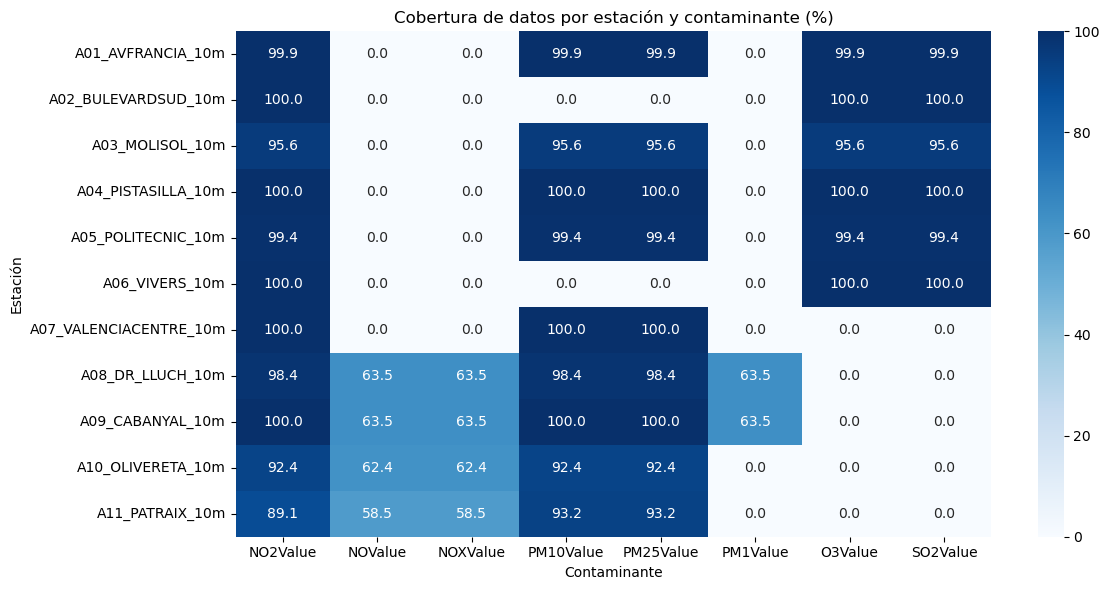

In [ ]:
# Crear tabla de cobertura (número de días con datos válidos)
cobertura = (
    datos_d_estacion
    .groupby('entityId')[contaminantes]
    .apply(lambda df: df.notna().sum())
)

# Convertir a porcentaje sobre el total de días por estación
total_dias_por_est = datos_d_estacion.groupby("entityId")["dateObserved"].nunique()
cobertura_pct = cobertura.divide(total_dias_por_est, axis=0) * 100

# Plot del heatmap de cobertura
plt.figure(figsize=(12, 6))
sns.heatmap(cobertura_pct, annot=True, fmt=".1f", cmap="Blues")
plt.title("Cobertura de datos por estación y contaminante (%)")
plt.xlabel("Contaminante")
plt.ylabel("Estación")
plt.tight_layout()
plt.show()

Antes de realizar el análisis de correlación por estación, se estudió la cobertura de datos para cada contaminante en cada ubicación. Se observó que variables como NO, NOX o PM1 tienen una cobertura nula en la mayoría de estaciones. Por otro lado, NO₂ y PM₂.₅ presentan una cobertura casi completa (>90% en la mayoría de estaciones), lo cual respalda su inclusión en análisis espaciales. O₃ y SO₂, aunque seleccionadas por sus propiedades químicas, no están disponibles en muchas estaciones, por lo que solo se considerarán cuando los datos lo permitan.

**Correlación lineal**

A01_AVFRANCIA_10m - Nº de días con datos por variable:
NO2Value     878
O3Value      878
PM25Value    878
SO2Value     878
dtype: int64



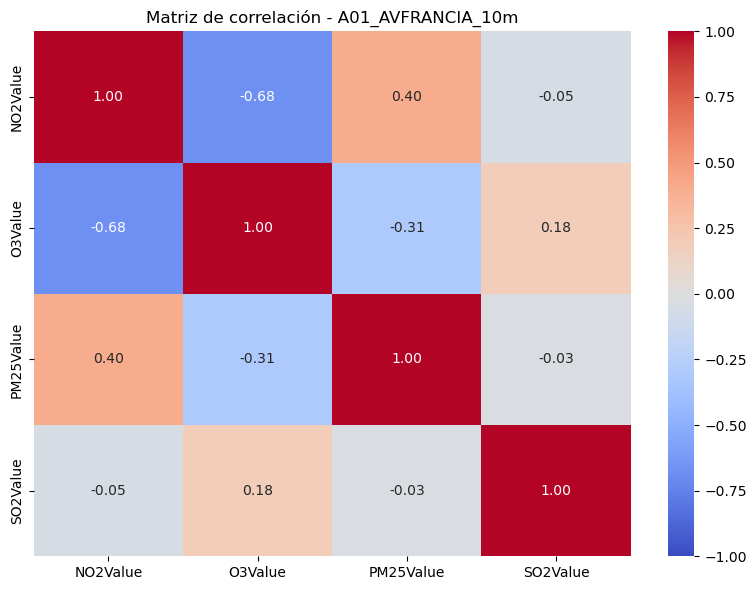

A02_BULEVARDSUD_10m - Nº de días con datos por variable:
NO2Value    879
O3Value     879
SO2Value    879
dtype: int64



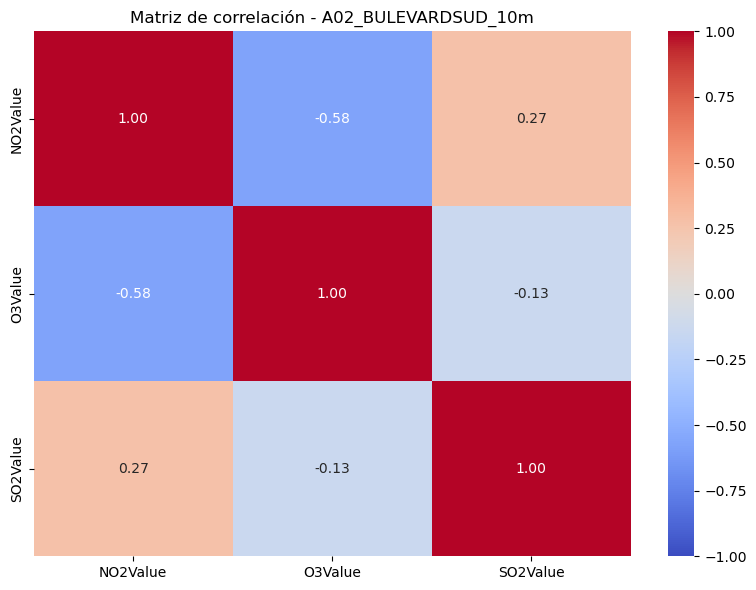

A03_MOLISOL_10m - Nº de días con datos por variable:
NO2Value     840
O3Value      840
PM25Value    840
SO2Value     840
dtype: int64



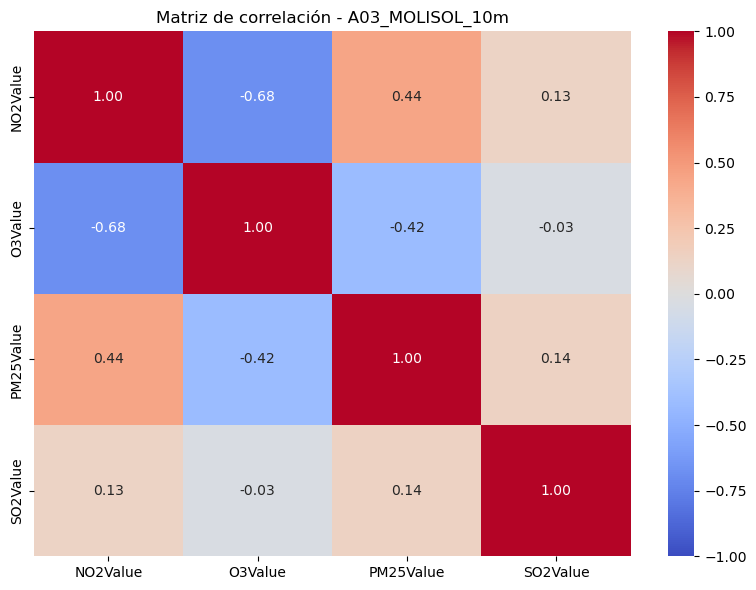

A04_PISTASILLA_10m - Nº de días con datos por variable:
NO2Value     879
O3Value      879
PM25Value    879
SO2Value     879
dtype: int64



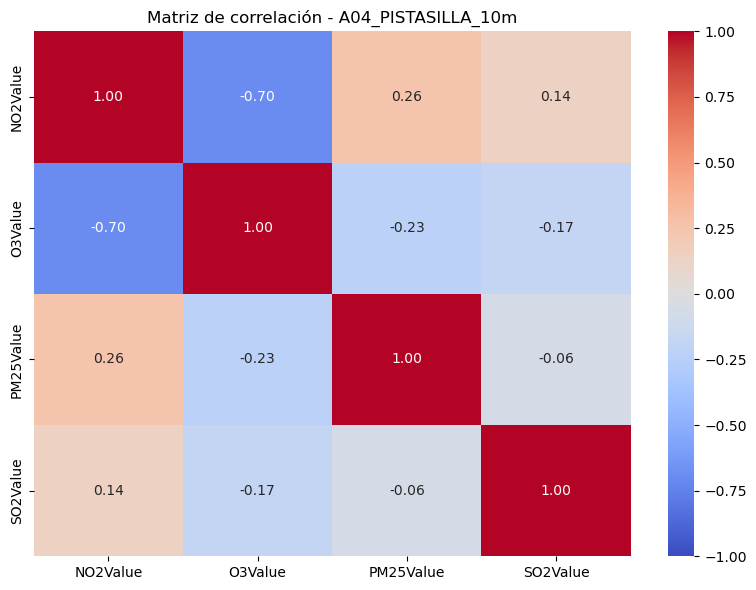

A05_POLITECNIC_10m - Nº de días con datos por variable:
NO2Value     874
O3Value      874
PM25Value    874
SO2Value     874
dtype: int64



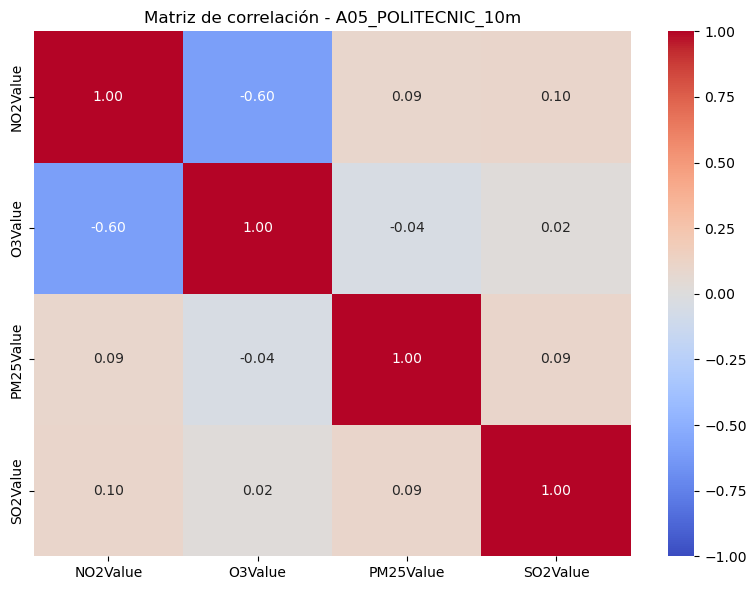

A06_VIVERS_10m - Nº de días con datos por variable:
NO2Value    879
O3Value     879
SO2Value    879
dtype: int64



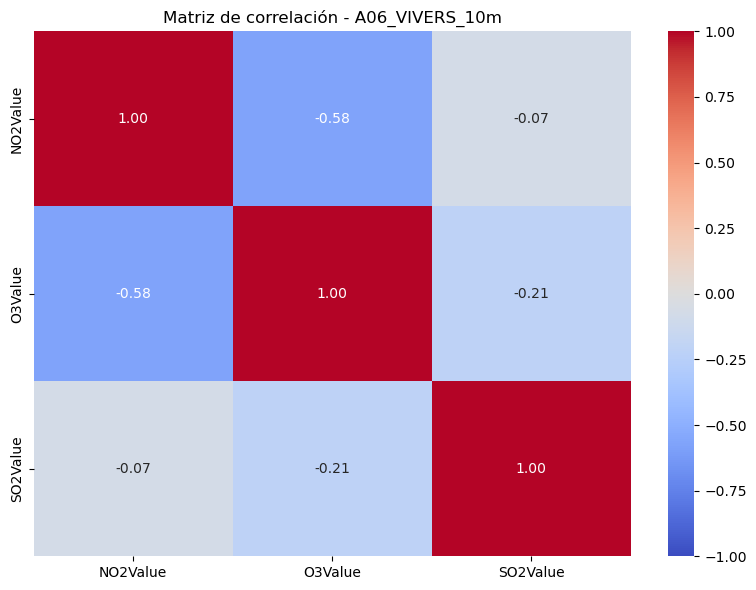

A07_VALENCIACENTRE_10m - Nº de días con datos por variable:
NO2Value     879
PM25Value    879
dtype: int64



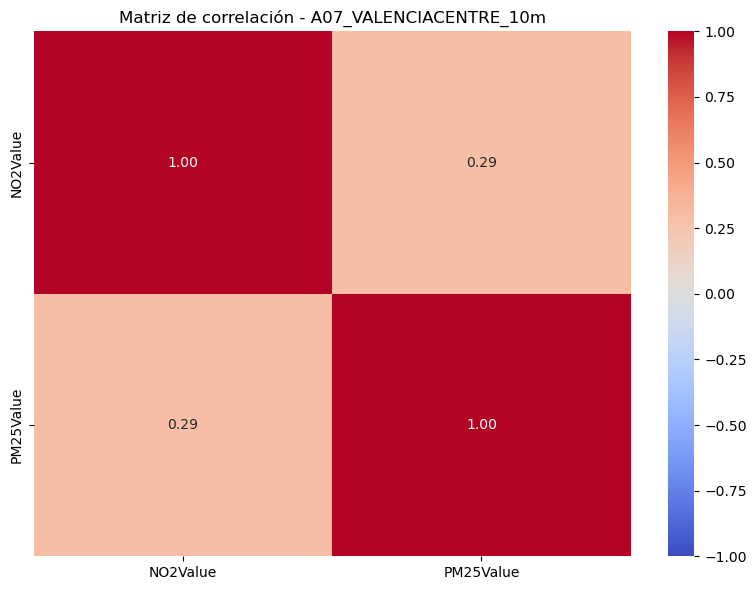

A08_DR_LLUCH_10m - Nº de días con datos por variable:
NO2Value     865
PM25Value    865
dtype: int64



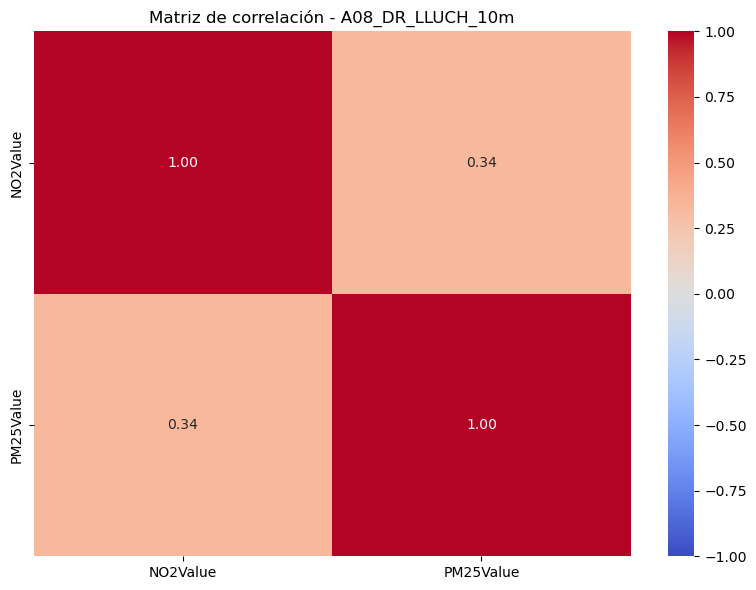

A09_CABANYAL_10m - Nº de días con datos por variable:
NO2Value     879
PM25Value    879
dtype: int64



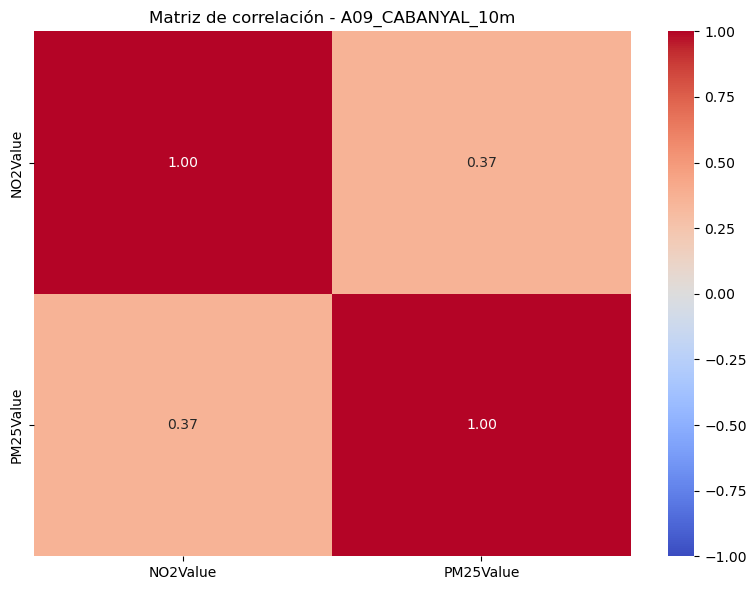

A10_OLIVERETA_10m - Nº de días con datos por variable:
NO2Value     776
PM25Value    776
dtype: int64



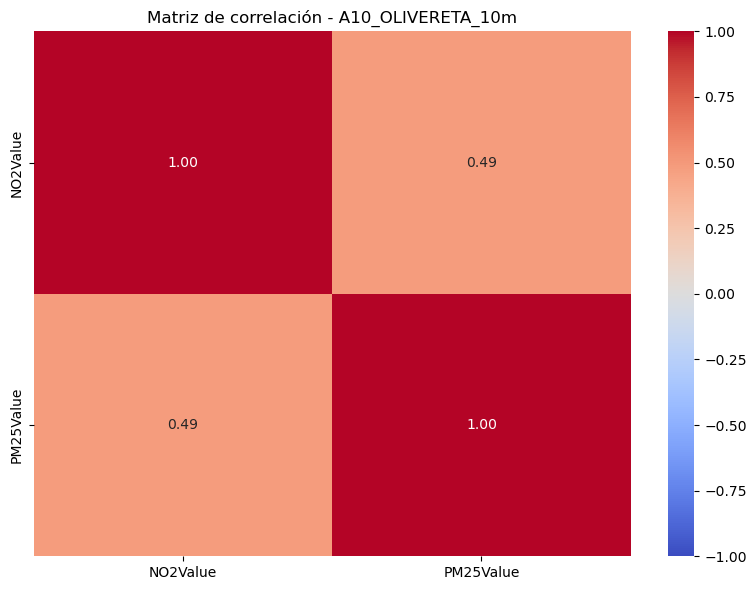

A11_PATRAIX_10m - Nº de días con datos por variable:
NO2Value     711
PM25Value    744
dtype: int64



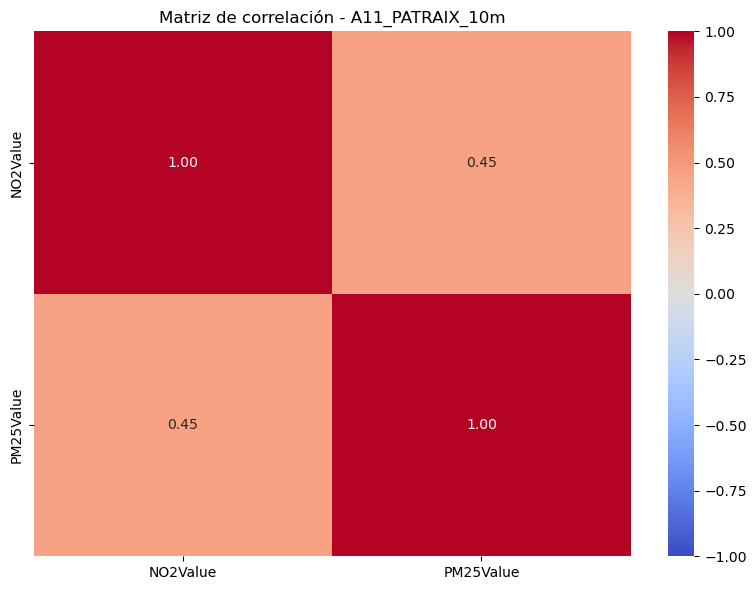

In [ ]:
contaminantes = ['NO2Value', 'O3Value', 'PM25Value', 'SO2Value']

# Lista automática de estaciones presentes en los datos
estaciones = datos_d_estacion['entityId'].unique()

import matplotlib.pyplot as plt
import seaborn as sns

for estacion in estaciones:
    df_est = datos_d_estacion[datos_d_estacion['entityId'] == estacion]
    #df_est = df_est[contaminantes]  # No dropna
    df_est = df_est[contaminantes].dropna(axis=1, how='all')

    # Calcular correlación con método pairwise (por defecto)
    corr_matrix = df_est.corr(method='pearson', min_periods=10)
    n_dias = df_est.notna().sum()
    print(f"{estacion} - Nº de días con datos por variable:\n{n_dias}\n")
    
    # Si hay al menos 2 columnas correlacionadas, visualizar
    if corr_matrix.shape[0] >= 2:
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
        plt.title(f"Matriz de correlación - {estacion}", fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        print(f"[{estacion}] No hay suficientes contaminantes con datos para correlación.")

Tras seleccionar las variables clave (NO₂, PM₂.₅, O₃, SO₂) y evaluar su cobertura por estación, se procedió a analizar la correlación lineal entre ellas de forma desagregada por estación. Esta fase del análisis buscaba entender si las relaciones entre contaminantes variaban espacialmente dentro de la ciudad de Valencia, y si dichas relaciones podrían estar influidas por las características del entorno urbano, el tráfico, o las condiciones atmosféricas locales.

En conjunto, este análisis apoya la decisión metodológica de seleccionar las variables NO₂, PM₂.₅, O₃ y SO₂, ya que capturan relaciones relevantes entre contaminantes primarios y secundarios, y permiten observar comportamientos diferenciados por zona. Además, la relativa estabilidad de las correlaciones por estación valida su uso como variables de entrada para posteriores análisis de modelado y detección de anomalías.

**Correlación multivariante**

Tras estudiar las correlaciones lineales entre contaminantes mediante matrices de calor por estación, se realizó un análisis multivariante visual utilizando diagramas de dispersión cruzados (pairplot). Este tipo de representación permite observar no solo la intensidad de la correlación entre variables, sino también la forma, tendencia y posibles patrones no lineales en las relaciones bivariadas entre contaminantes.

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2223438434.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


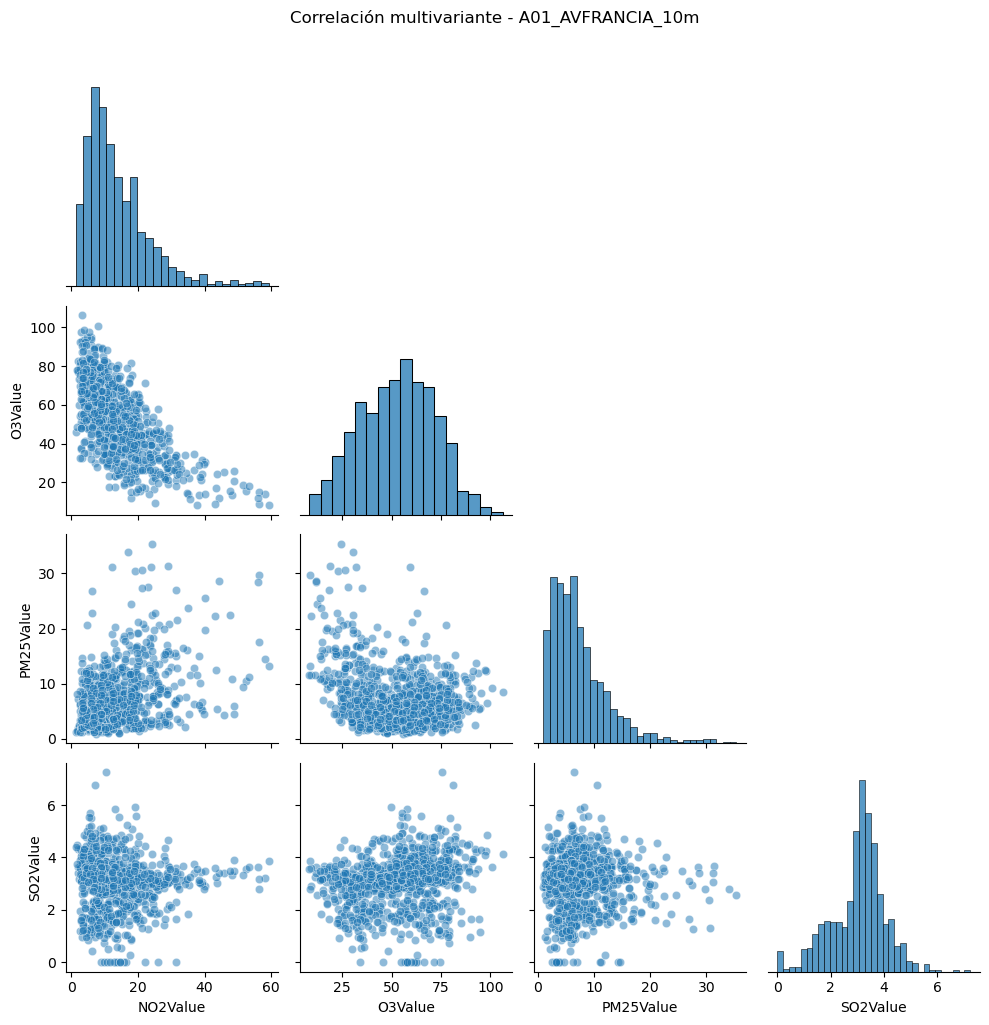

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2223438434.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


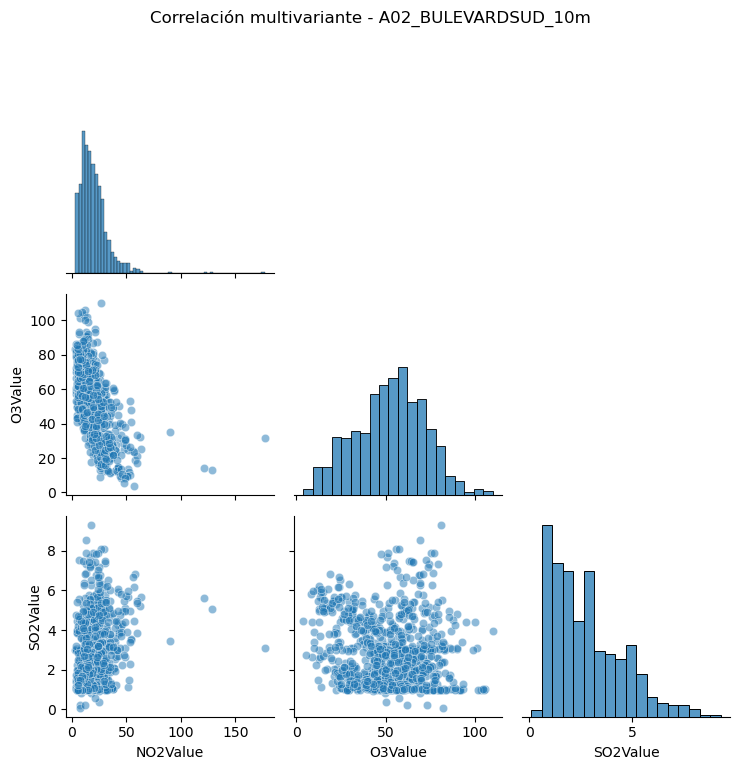

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2223438434.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


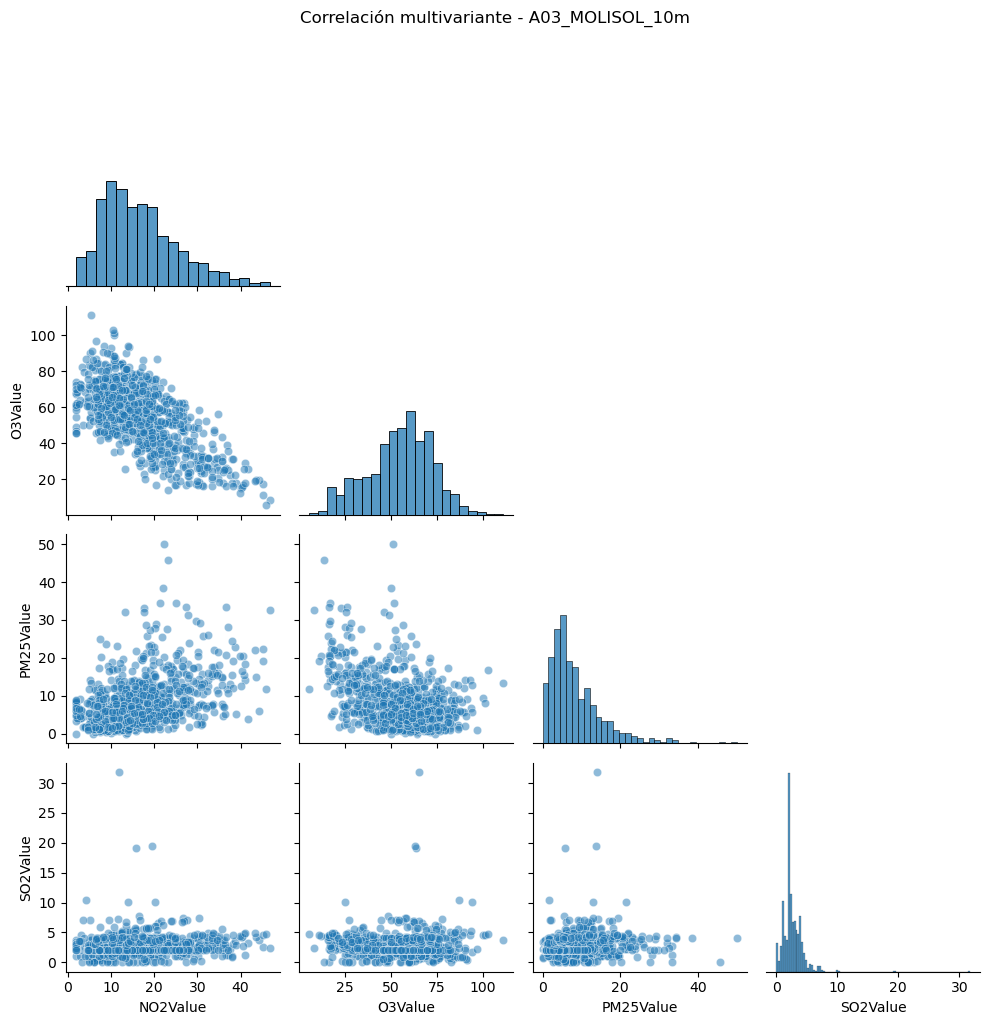

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2223438434.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


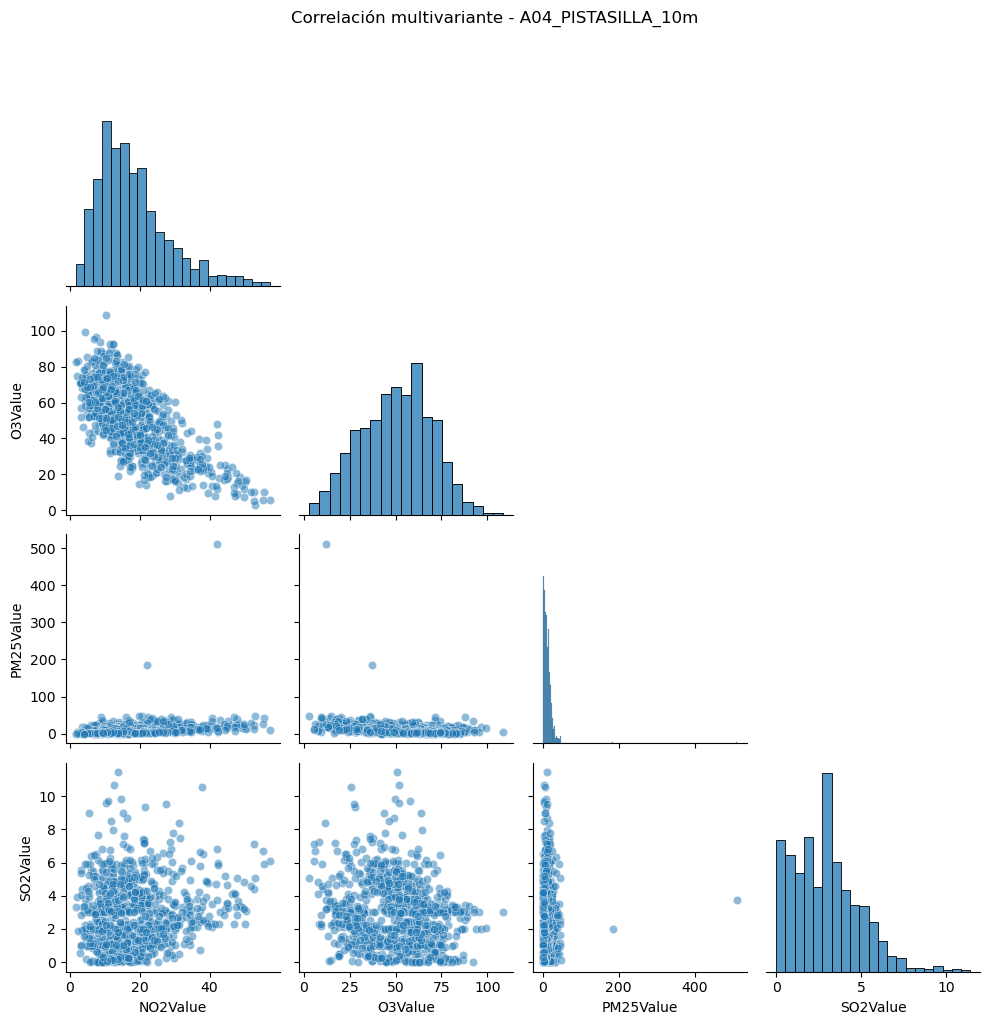

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2223438434.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


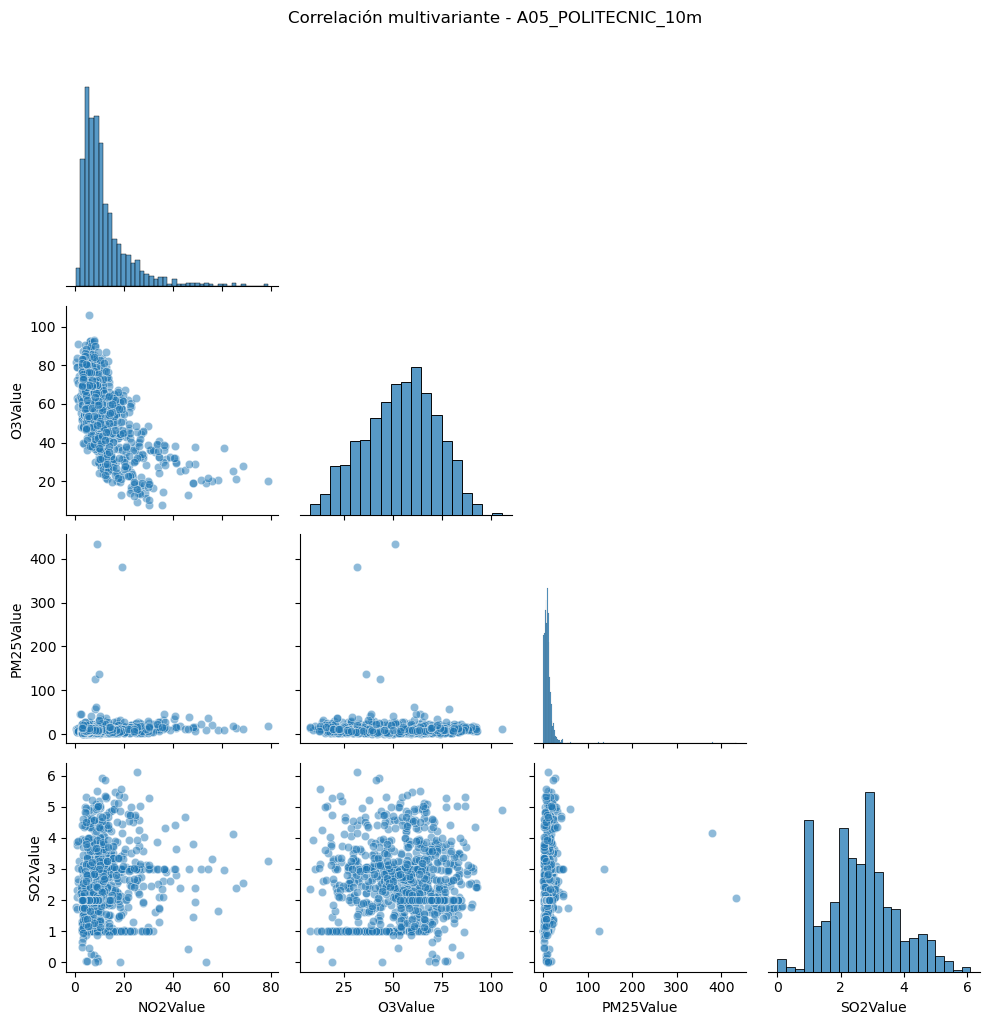

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2223438434.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


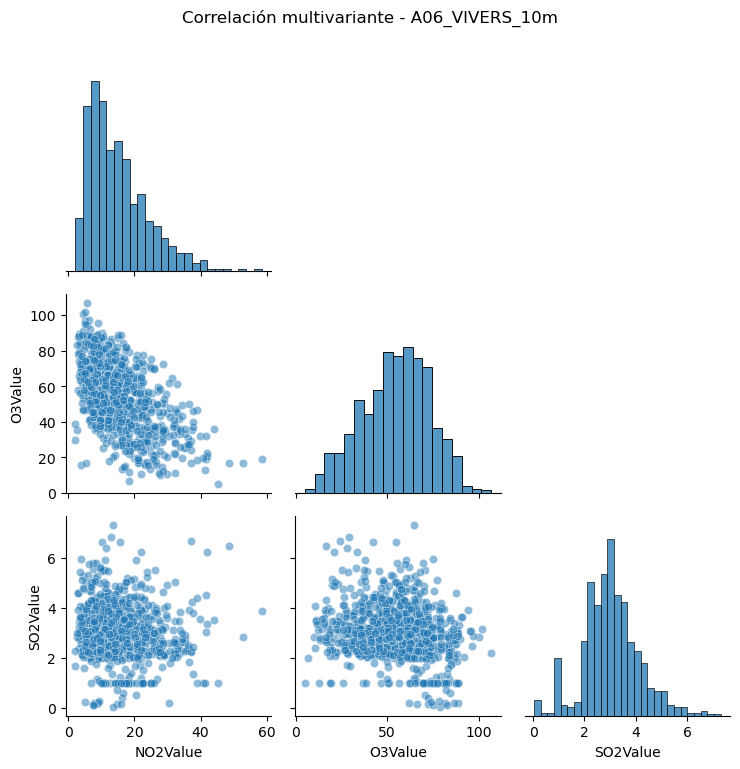

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2223438434.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


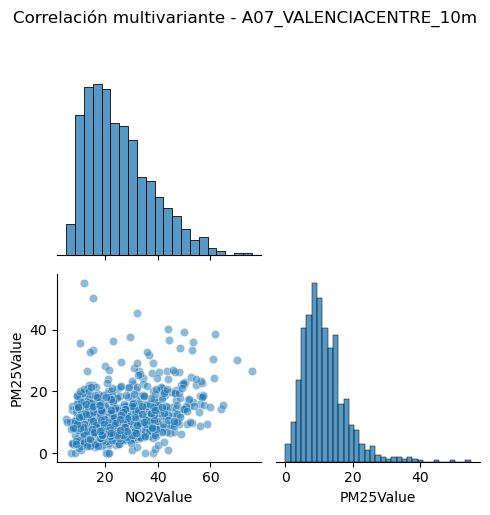

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2223438434.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


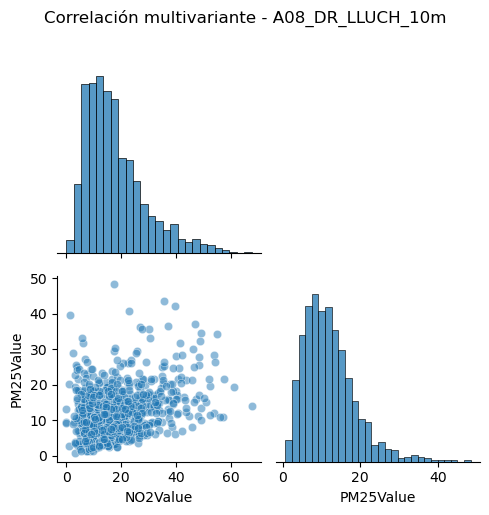

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2223438434.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


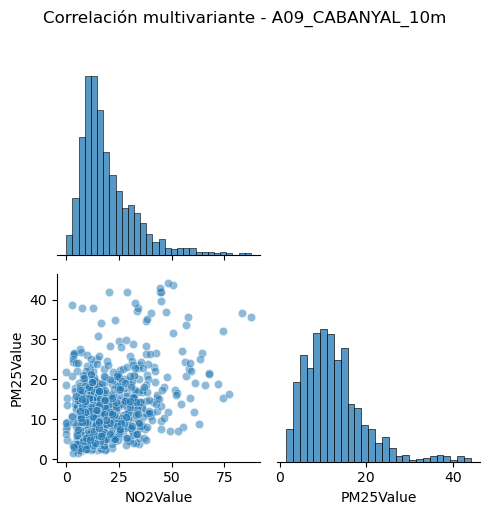

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2223438434.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


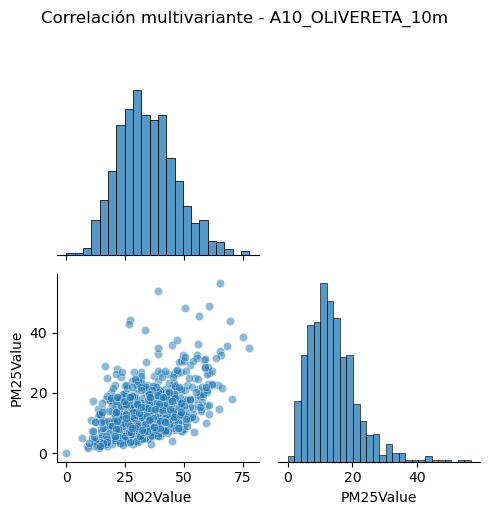

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2223438434.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


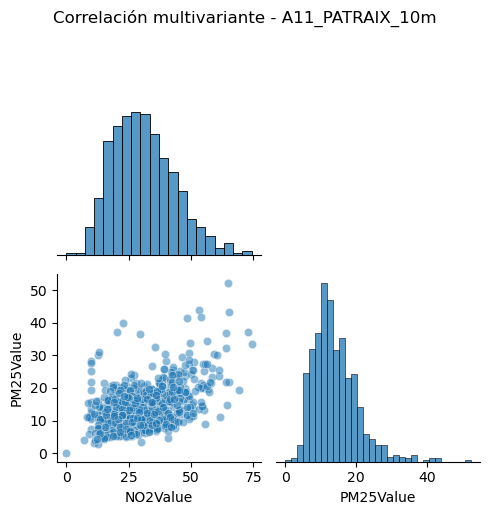

In [ ]:
for estacion in estaciones:
    df_est = datos_d_estacion[datos_d_estacion['entityId'] == estacion]
    df_vars = df_est[contaminantes].dropna(axis=1, how='all')

    if len(df_vars) > 30:
        # Crear pairplot (multivariante)
        g = sns.pairplot(df_vars, corner=True, plot_kws={'alpha': 0.5})
        g.fig.suptitle(f"Correlación multivariante - {estacion}", y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print(f"[{estacion}] Pairplot omitido: no hay suficientes datos.")


Este análisis confirma visualmente que las relaciones entre contaminantes no son siempre lineales ni constantes entre estaciones. En particular, la relación inversa entre NO₂ y O₃ se mantiene en todas las estaciones donde ambos están disponibles, aunque con diferentes pendientes y dispersión. Además, en varias estaciones (PISTASILLA, POLITECNIC, MOLISOL, OLIVERETA) se identifican valores de PM₂.₅ inusualmente altos que podrían anticipar episodios contaminantes o errores instrumentales, lo que será explorado posteriormente en la fase de detección de anomalías.

Este tipo de análisis multivariante visual no solo valida la selección de contaminantes a monitorizar, sino que también orienta la elección de estaciones clave para aplicar técnicas de detección (como STL o umbrales dinámicos), al identificar aquellas donde las relaciones presentan comportamientos menos estables o distribuciones más dispersas.

## Análisis temporal

### Análisis temporal global

El análisis temporal permite comprender el comportamiento dinámico de los contaminantes atmosféricos y detectar patrones estacionales o vinculados a la actividad humana. Para ello, se ha estudiado la evolución mensual y la diferencia entre días laborables y fines de semana de los principales contaminantes medidos en la ciudad de Valencia entre 2022 y 2024.

En primer lugar, se ha representado la evolución mensual media de las concentraciones de NO₂, O₃, PM₂.₅ y SO₂ considerando conjuntamente todas las estaciones de medición. El objetivo era identificar tendencias estacionales generales.

- Agrupa los datos por año y mes, y calcula la media de cada contaminante en ese mes.
- DataFrame con la media mensual para cada contaminante, cada año por separado.

In [ ]:
def analisis_temporal(df, nombre):
    df = df.copy()
    contaminantes = ['NO2Value', 'O3Value', 'PM25Value', 'SO2Value']

    # Asegurar que 'dateObserved' está como datetime y accesible
    if 'dateObserved' not in df.columns:
        df['dateObserved'] = df.index
    df['dateObserved'] = pd.to_datetime(df['dateObserved'])

    # Columnas temporales
    df['Año'] = df['dateObserved'].dt.year
    df['Mes'] = df['dateObserved'].dt.month
    df['DiaSemana'] = df['dateObserved'].dt.dayofweek
    df['Es_finde'] = df['DiaSemana'].isin([5, 6])

    # Evolución mensual
    mensual = df.groupby(['Año', 'Mes'])[contaminantes].mean().reset_index()
    mensual_melt = mensual.melt(id_vars=['Año', 'Mes'], value_vars=contaminantes)

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=mensual_melt, x='Mes', y='value', hue='variable', ci='sd')
    plt.title(f"Evolución mensual media por contaminante ({nombre})")
    plt.xlabel("Mes")
    plt.ylabel("Concentración media (µg/m³)")
    plt.xticks(ticks=range(1, 13), labels=calendar.month_name[1:], rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Comparación días laborables VS fines de semana
    fines_vs_laborables = df.groupby('Es_finde')[contaminantes].mean().reset_index()
    fines_vs_laborables['Es_finde'] = fines_vs_laborables['Es_finde'].map({True: 'Finde semana', False: 'Laborable'})
    fines_melt = fines_vs_laborables.melt(id_vars='Es_finde', value_vars=contaminantes,
                                           var_name='Contaminante', value_name='Concentración media')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=fines_melt, x='Contaminante', y='Concentración media', hue='Es_finde', palette='Set2')
    plt.title(f"Laborables vs Fines de semana ({nombre})", fontsize=14)
    plt.xlabel("Contaminante")
    plt.ylabel("Concentración media (µg/m³)")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\1582184996.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=mensual_melt, x='Mes', y='value', hue='variable', ci='sd')


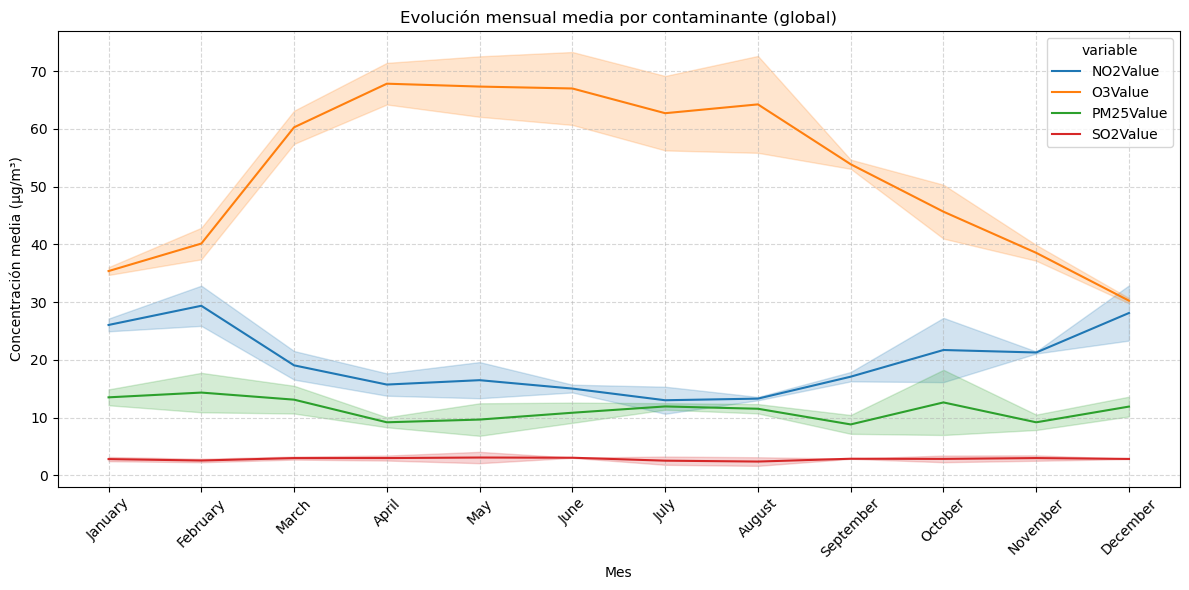

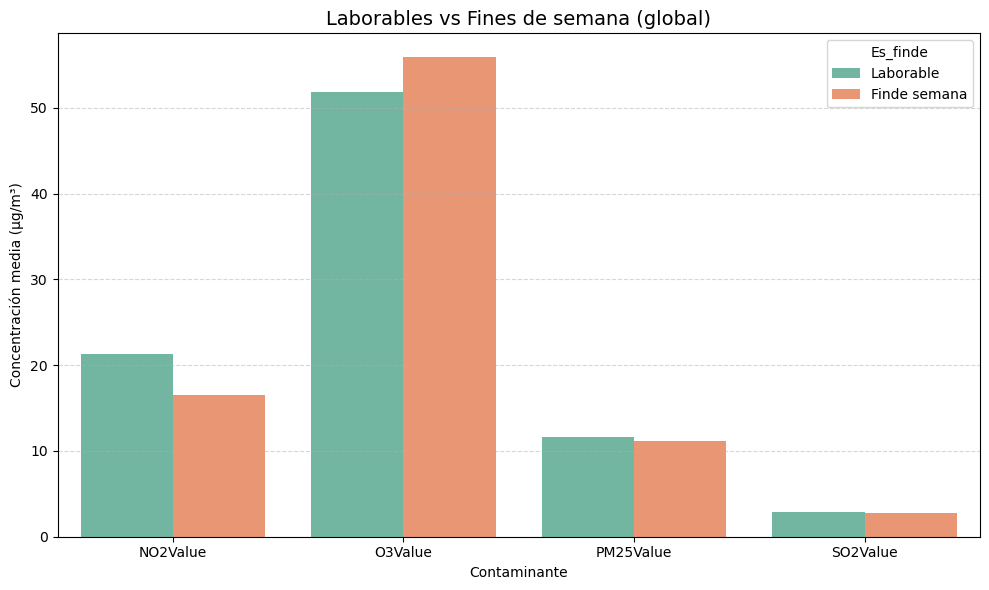

In [ ]:
analisis_temporal(datos_d_global, nombre="global")

El análisis temporal permite comprender el comportamiento dinámico de los contaminantes atmosféricos y detectar patrones estacionales o vinculados a la actividad humana. Para ello, se ha estudiado la evolución mensual y la diferencia entre días laborables y fines de semana de los principales contaminantes medidos en la ciudad de Valencia entre 2022 y 2024.

En primer lugar, se ha representado la evolución mensual media de las concentraciones de NO₂, O₃, PM₂.₅ y SO₂ considerando conjuntamente todas las estaciones de medición. El objetivo era identificar tendencias estacionales generales.



Los resultados muestran un comportamiento claramente diferenciado entre los contaminantes:

- Dióxido de nitrógeno (NO₂) presenta valores más altos en los meses fríos (invierno y otoño) y disminuye durante los meses cálidos. Esta estacionalidad es coherente con su origen principal en el tráfico rodado y la menor dispersión atmosférica en invierno. Además, durante los meses cálidos se observa una menor emisión y mayor dispersión.

- Ozono troposférico (O₃) muestra un patrón opuesto: su concentración aumenta progresivamente desde febrero hasta alcanzar un máximo en verano (mayo-julio), para luego descender. Esto se debe a que el ozono no se emite directamente, sino que se forma por reacciones fotoquímicas que requieren radiación solar, más intensa en verano.

- PM₂.₅ presenta una distribución más homogénea a lo largo del año, aunque con una ligera disminución en primavera-verano. Esto sugiere una mezcla de fuentes de emisión, tanto fijas como móviles, que afectan de manera más constante a lo largo del tiempo.

- SO₂ presenta concentraciones muy bajas y sin estacionalidad destacable, lo que podría indicar que las fuentes de emisión de este contaminante (por ejemplo, combustión de ciertos combustibles fósiles) no son dominantes ni varían significativamente a lo largo del año en el área de estudio.

Adicionalmente, se compararon los niveles de contaminación entre días laborables y fines de semana. Este análisis permite valorar el impacto de las actividades humanas, particularmente del tráfico, sobre la calidad del aire:

- NO₂ disminuye notablemente durante los fines de semana, reflejando la reducción del tráfico y otras actividades urbanas.

- En cambio, O₃ tiende a aumentar durante los fines de semana. Este fenómeno es conocido como efecto fin de semana y se debe a la reducción de emisiones de NO, que normalmente actúan destruyendo el ozono.

- PM₂.₅ y SO₂ no muestran diferencias significativas, lo que sugiere que sus fuentes no están tan ligadas a la actividad laboral diaria o que presentan un comportamiento más constante.

Este análisis global ofrece una primera visión agregada del comportamiento de los contaminantes en Valencia. No obstante, resulta fundamental analizar si estas tendencias se replican en todas las estaciones o si existen diferencias locales, lo cual se aborda en el siguiente apartado.

### Análisis temporal por estación

A continuación se analizan los patrones de variación mensual de los contaminantes NO₂, O₃, PM₂.₅ y SO₂ en las distintas estaciones de medición de Valencia. Este análisis permite identificar diferencias geográficas en la evolución temporal de los contaminantes, así como estaciones con comportamientos atípicos o poco consistentes.


En el análisis temporal por estación, cada gráfico muestra la evolución mensual de la concentración media de un contaminante específico (por ejemplo, NO₂, O₃, PM₂.₅ o SO₂) a lo largo del periodo 2022–2024 para una estación concreta de medición.

Cada punto representado en estos gráficos corresponde a la media mensual del contaminante en una estación determinada. Es decir, para cada combinación de estación, año y mes, se calcula la media aritmética de todas las mediciones diarias disponibles en ese intervalo temporal.

Por ejemplo, si en la estación A01_AVFRANCIA_10m se registraron 28 valores diarios de NO₂ durante febrero de 2023, el punto correspondiente a ese mes representa la media de esos 28 valores diarios. Esta agregación mensual permite suavizar la variabilidad diaria y facilita la identificación de tendencias estacionales o posibles comportamientos anómalos.

Fórmula utilizada:

Valor_mensual = (1/n) * Σ Cᵢ

Donde:
- Cᵢ es la concentración diaria del contaminante en el día i.
- n es el número de días con datos válidos en ese mes y estación.

Este enfoque permite:
- Visualizar patrones temporales diferenciados entre estaciones.
- Comparar la intensidad media de los contaminantes entre distintas zonas de la ciudad.
- Identificar estaciones con valores atípicos o patrones irregulares.

En definitiva, los gráficos proporcionan una herramienta visual clara para comprender la dinámica estacional y espacial de la contaminación atmosférica en Valencia.

In [ ]:
def analisis_temporal_estaciones(df, variable, cont=None):
    df = df.copy()
    df['dateObserved'] = pd.to_datetime(df['dateObserved'])
    df['Mes'] = df['dateObserved'].dt.month
    df['Año'] = df['dateObserved'].dt.year
    df['DiaSemana'] = df['dateObserved'].dt.dayofweek
    df['Es_finde'] = df['DiaSemana'].isin([5, 6])

    ### Evolución mensual
    df_mensual = df.groupby(['entityId', 'Año', 'Mes'])[variable].mean().reset_index()
    df_mensual['Fecha'] = pd.to_datetime(df_mensual['Año'].astype(str) + '-' + df_mensual['Mes'].astype(str))
    estaciones = df_mensual['entityId'].unique()

    n = len(estaciones)
    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3.5 * rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, estacion in enumerate(estaciones):
        datos_est = df_mensual[df_mensual['entityId'] == estacion]
        axes[i].plot(datos_est['Fecha'], datos_est[variable], marker='o')
        axes[i].set_title(estacion, fontsize=9)
        axes[i].tick_params(axis='x', labelrotation=30)
        axes[i].grid(True, linestyle='--', alpha=0.3)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"Evolución mensual de {nombre_limpio} por estación", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    ### Comparación días laborables y fines de semana
    resumen = df.groupby(['entityId', 'Es_finde'])[variable].mean().reset_index()
    resumen['Tipo día'] = resumen['Es_finde'].map({True: 'Finde semana', False: 'Laborable'})

    g = sns.catplot(
        data=resumen,
        x='entityId', y=variable, hue='Tipo día',
        kind='bar', height=5, aspect=2, palette='Set2'
    )
    g.set_titles("")
    g.set_axis_labels("Estación", f"Concentración media de {nombre_limpio} (µg/m³)")
    g.set_xticklabels(rotation=45)
    plt.title(f"Días laborables vs Fines de semana por estación ({nombre_limpio})", fontsize=14)
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.4)
    plt.show()


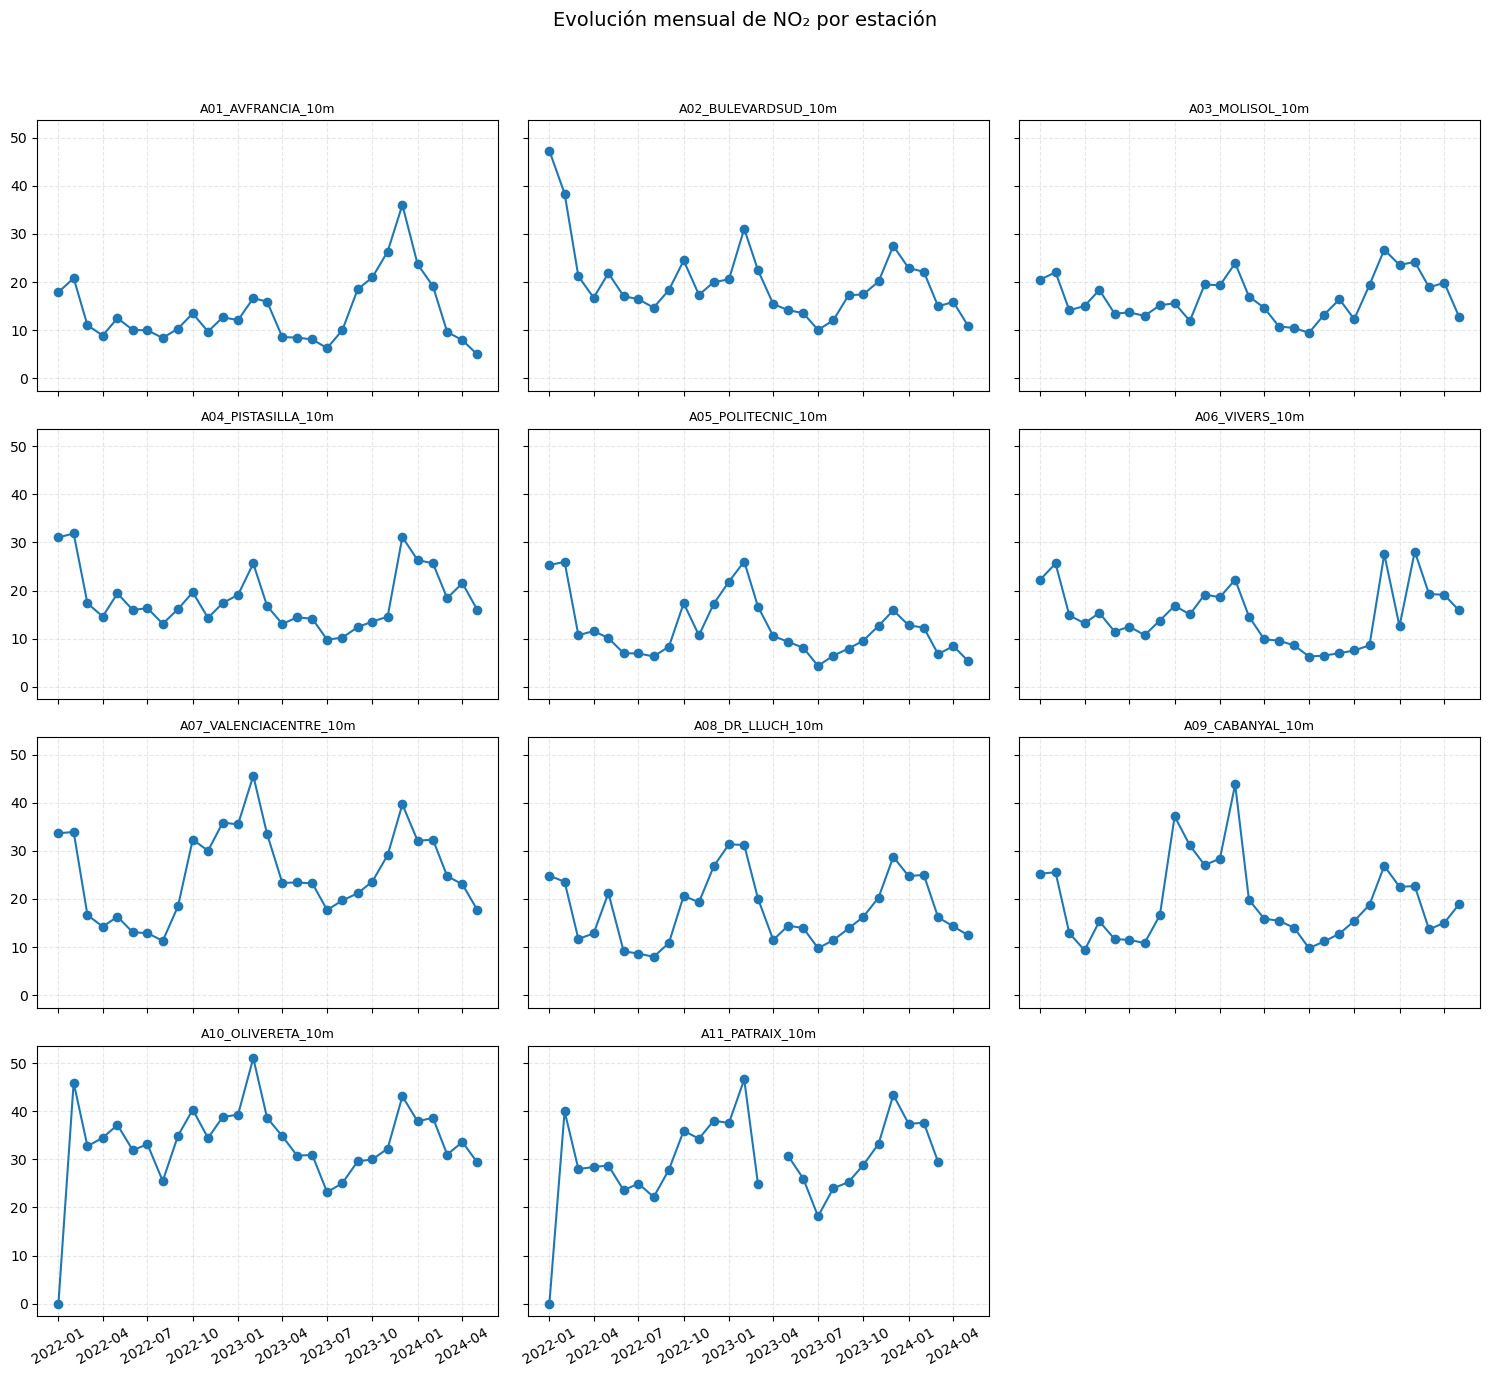

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2104665245.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


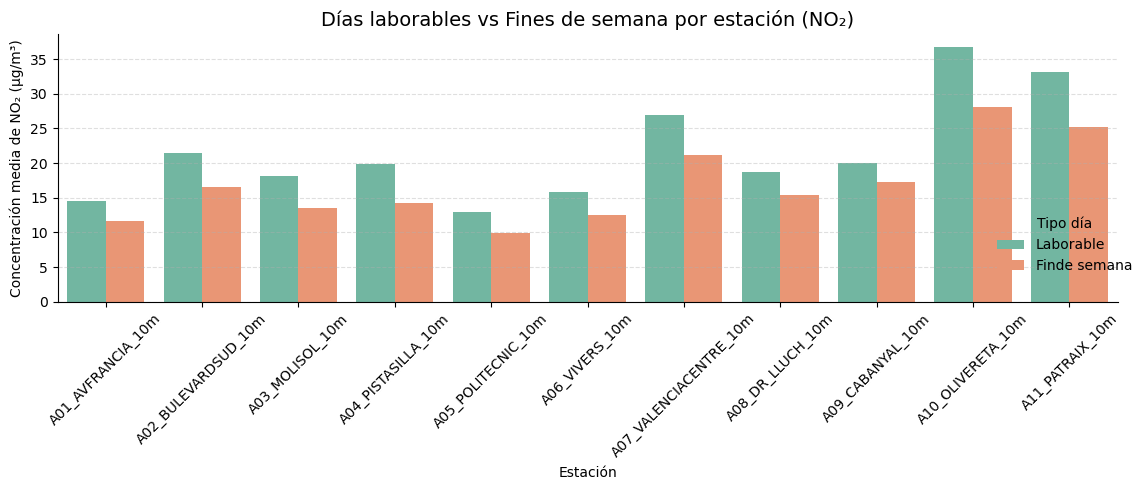

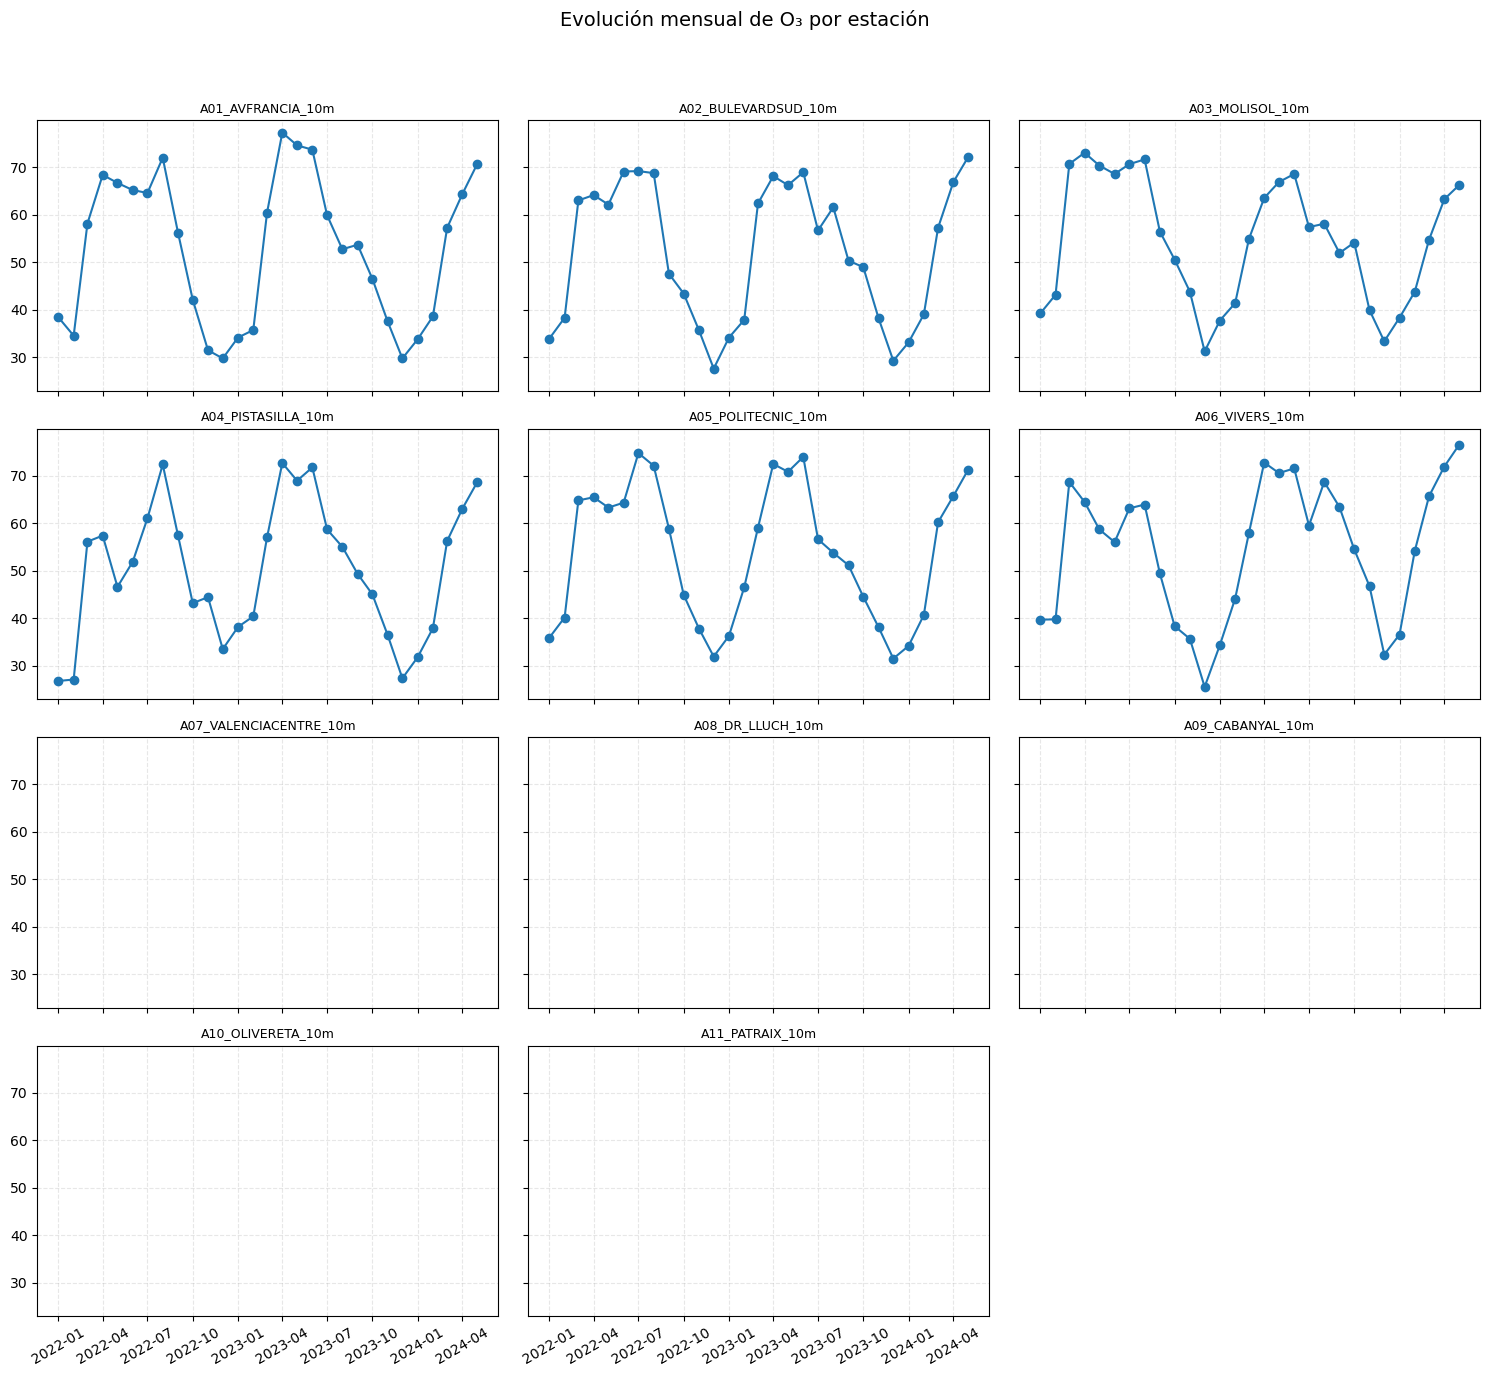

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2104665245.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


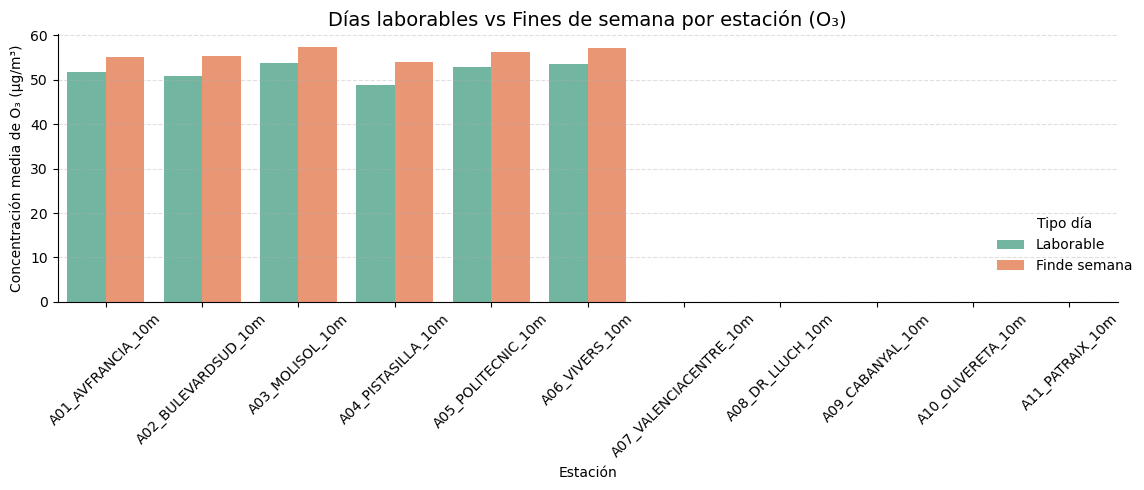

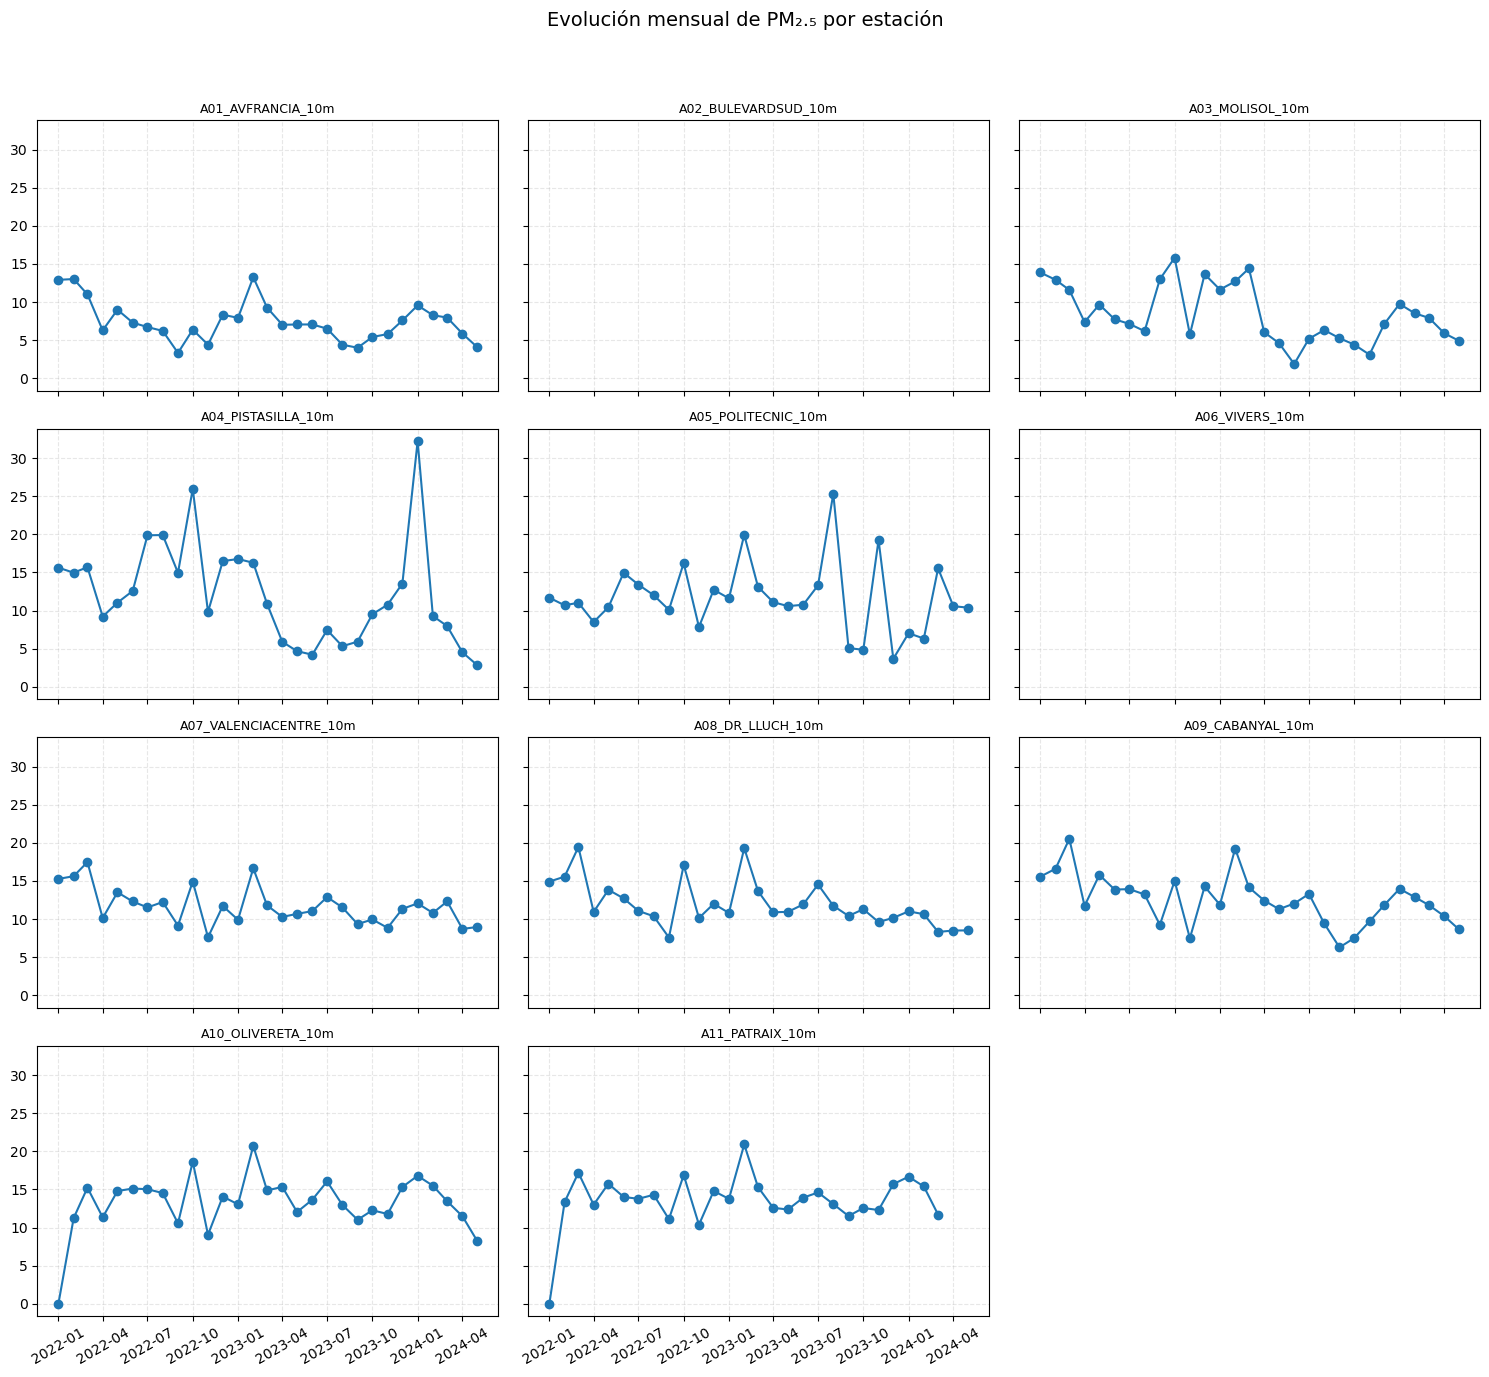

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2104665245.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


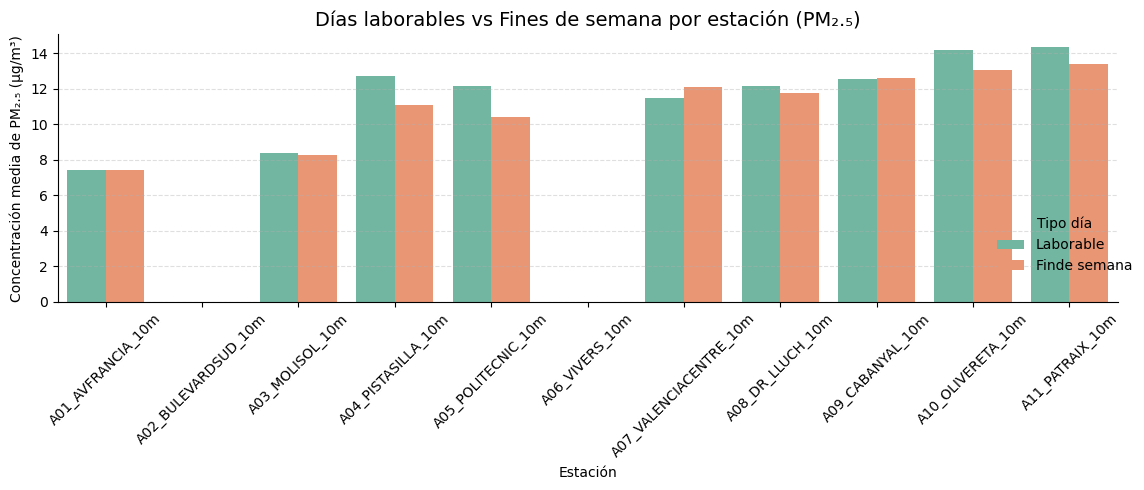

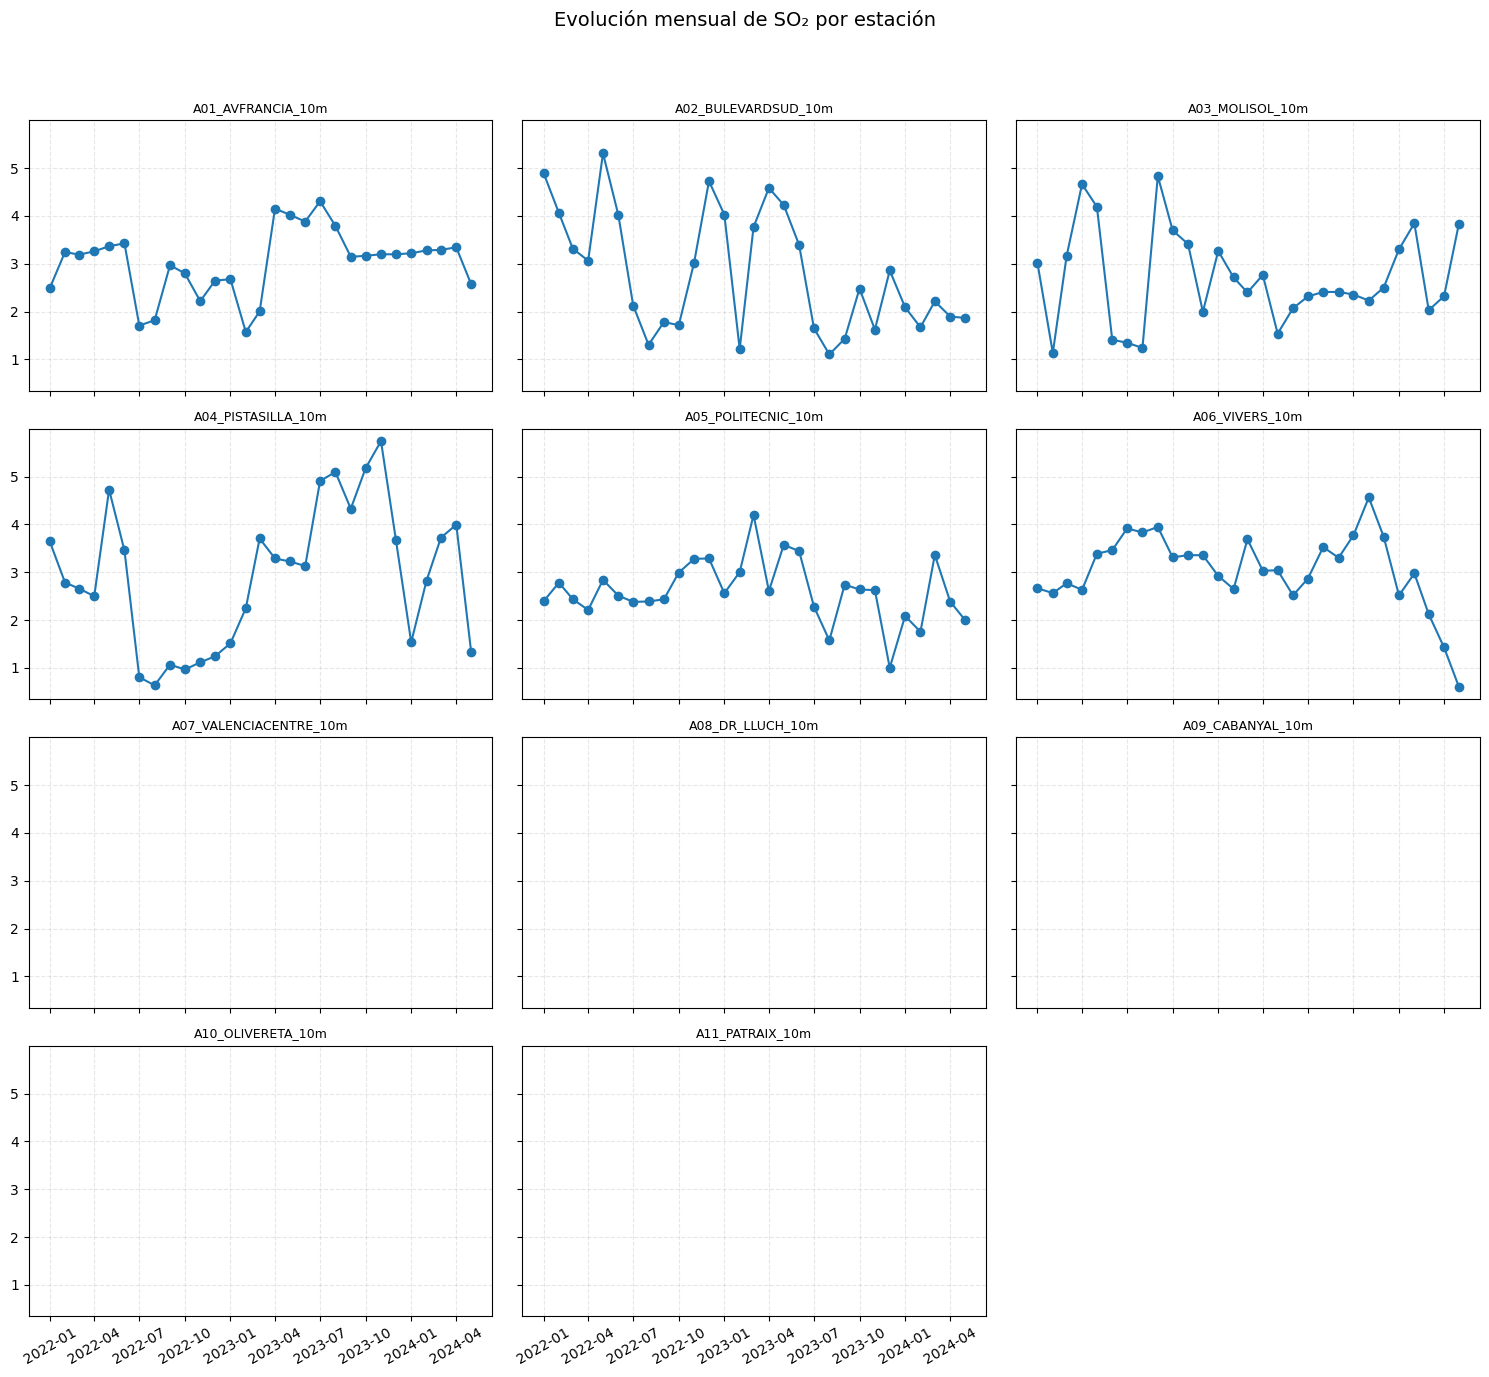

c:\Users\Lucia\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_14120\2104665245.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


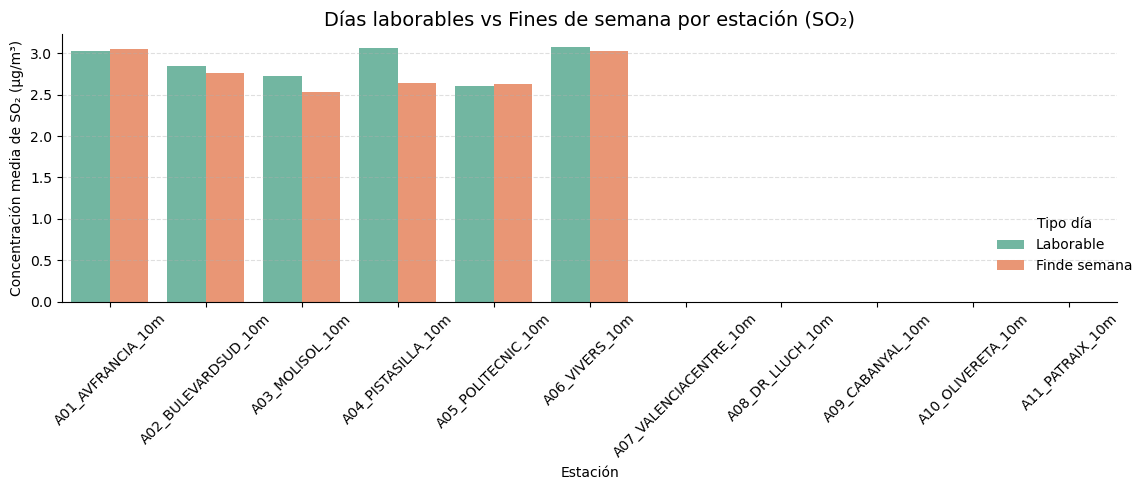

In [ ]:
analisis_temporal_estaciones(datos_d_estacion, 'NO2Value', 'NO₂')
analisis_temporal_estaciones(datos_d_estacion, 'O3Value', 'O₃')
analisis_temporal_estaciones(datos_d_estacion, 'PM25Value', 'PM₂.₅')
analisis_temporal_estaciones(datos_d_estacion, 'SO2Value', 'SO₂')


**Evolución mensual de los contaminantes**

La evolución mensual por estación permite identificar patrones estacionales y variabilidad local en cada ubicación. A continuación se analizan individualmente los contaminantes clave:

1. Dióxido de nitrógeno (NO₂)

    Estacionalidad clara en la mayoría de estaciones, con máximos invernales y descensos durante verano, como en el patrón global.

    Estaciones como A01_AVFRANCIA, A07_VALENCIACENTRE o A10_OLIVERETA presentan valores más elevados de forma sostenida, lo que podría indicar mayor exposición al tráfico o a entornos urbanos densos.

    A08_DR_LLUCH y A09_CABANYAL presentan valores más bajos y un perfil más plano, consistente con entornos residenciales o costeros.

    La variabilidad entre meses parece mayor en estaciones como A11_PATRAIX y A05_POLITECNIC, lo que sugiere sensibilidad a cambios puntuales o menor estabilidad en la serie temporal.

    NO₂ mantiene un patrón estacional generalizado, aunque con diferencias significativas en magnitud según la ubicación.

2. Ozono (O₃)
    
    La estacionalidad es fortísima: se observa el mismo ciclo anual con picos entre mayo y agosto en todas las estaciones que disponen de datos.

    Sin embargo, faltan datos en estaciones como A07_VALENCIACENTRE, A08_DR_LLUCH, A09_CABANYAL, A10_OLIVERETA y A11_PATRAIX, lo que limita el análisis en esas zonas.

    Estaciones como A04_PISTASILLA y A06_VIVERS muestran el patrón estacional muy nítido y pueden ser representativas del comportamiento típico del ozono en entornos abiertos y soleados.

    El patrón estacional es consistente, pero el problema de cobertura obliga a seleccionar solo estaciones con datos completos para este contaminante.

3. Partículas finas (PM₂.₅)
    
    Presenta una evolución más irregular entre estaciones. Algunas como A04_PISTASILLA muestran picos puntuales (posibles anomalías o eventos extraordinarios).

    Muchas estaciones tienen un comportamiento plano sin estacionalidad clara, pero sí con fluctuaciones mensuales grandes, posiblemente asociadas a episodios de intrusión de polvo o condiciones meteorológicas.

    El comportamiento de A02_BULEVARDSUD y A03_MOLISOL muestra curvas incompletas o muy planas, lo que podría indicar problemas de sensor o baja variabilidad.

    La serie PM₂.₅ es más heterogénea y con menor estacionalidad clara. Se requiere análisis de calidad antes de incluir ciertas estaciones en modelado.

4. Dióxido de azufre (SO₂)

    En general, las concentraciones son bajas y variables, sin un patrón estacional claro.

    Se detectan valores erráticos y gran dispersión en estaciones como A02_BULEVARDSUD, A03_MOLISOL o A05_POLITECNIC, lo que sugiere ruido o baja señal.

    Algunas estaciones directamente carecen de datos útiles, como las últimas del gráfico (A10, A11…).

    SO₂ muestra un perfil muy inestable y con poca cobertura útil, por lo que debe manejarse con precaución o excluirse en ciertos análisis.


NO₂ y O₃ son los contaminantes que mejor muestran patrones temporales consistentes por estación.

PM₂.₅ y SO₂ requieren análisis adicional por su mayor dispersión o cobertura limitada.

Se justifica incluir solo estaciones con suficiente cobertura y comportamiento coherente.

El análisis por estación permite identificar estaciones como VALENCIACENTRE, AVFRANCIA, VIVERS o PISTASILLA como candidatas sólidas para análisis de anomalías o modelado.

**Diferencias entre días laborables y fines de semana**

- NO₂:

    En todas las estaciones con datos, se observa una disminución significativa de NO₂ durante los fines de semana, confirmando su vinculación directa con el tráfico urbano.

    Este comportamiento refuerza la utilidad del NO₂ como indicador de actividad humana y es clave para estrategias de control del tráfico y reducción de emisiones.

- O₃:

    En contraste, el O₃ muestra niveles ligeramente más altos durante los fines de semana, lo que está bien documentado en literatura como el "efecto fin de semana": menor NO para reaccionar con O₃ → se acumula más.

    Las diferencias son pequeñas, pero constantes en todas las estaciones con datos.

- PM₂.₅:

    Se observa una tendencia general a niveles mayores en días laborables, aunque con variabilidad entre estaciones.

    Esto sugiere que además del tráfico, puede haber influencia de fuentes puntuales o locales (obras, calefacciones, polvo).

- SO₂:

    Prácticamente no hay diferencias significativas entre laborables y fines de semana, lo que respalda que no está directamente ligado a la actividad diaria urbana.


El análisis temporal por estación revela patrones estacionales y diferencias semanales claras para los contaminantes analizados.

NO₂ y O₃ muestran estacionalidades marcadas y complementarias, ideales para modelado y detección de anomalías.

PM₂.₅ presenta una mayor variabilidad entre estaciones, posiblemente debido a su sensibilidad a fuentes locales.

SO₂, aunque con datos limitados, muestra bajo impacto general.

## Descomposición STL

In [7]:
contaminantes = ['NO2', 'O3', 'PM25', 'SO2']
estaciones = ['A01_AVFRANCIA_10m', 'A02_BULEVARDSUD_10m', 'A03_MOLISOL_10m',
              'A04_PISTASILLA_10m','A05_POLITECNIC_10m','A06_VIVERS_10m', 
              'A07_VALENCIACENTRE_10m','A08_DR_LLUCH_10m','A09_CABANYAL_10m',
              'A10_OLIVERETA_10m', 'A11_PATRAIX_10m']

# Función para analizar y mostrar gráficos
def analizar_stl_mostrar(serie, nombre_contaminante, titulo_extra=""):
    if len(serie) == 0:
        print(f"[Aviso] Serie vacía: {nombre_contaminante} {titulo_extra}")
        return

    # STL Decomposition
    stl = STL(serie, period=365)
    resultado_stl = stl.fit()

    # Gráfica STL
    #resultado_stl.plot()
    fig = resultado_stl.plot()
    for ax in fig.axes:
        for label in ax.get_xticklabels():
            label.set_rotation(45)   # ángulo
            label.set_ha('right')
    plt.suptitle(f'STL Decomposition - {nombre_contaminante} {titulo_extra}', fontsize=14)
    plt.tight_layout()
    plt.show()

### Análisis global

Con el objetivo de analizar en detalle los patrones temporales de las concentraciones de contaminantes atmosféricos, se ha aplicado una descomposición STL (Seasonal-Trend decomposition using Loess) a los datos diarios globales de cuatro contaminantes clave: dióxido de nitrógeno (NO₂), ozono troposférico (O₃), partículas en suspensión finas (PM₂.₅) y dióxido de azufre (SO₂). Esta técnica permite separar la serie temporal original en tres componentes principales: tendencia, estacionalidad y residuo.

C:\Users\Lucia\AppData\Local\Temp\ipykernel_21068\1879058692.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


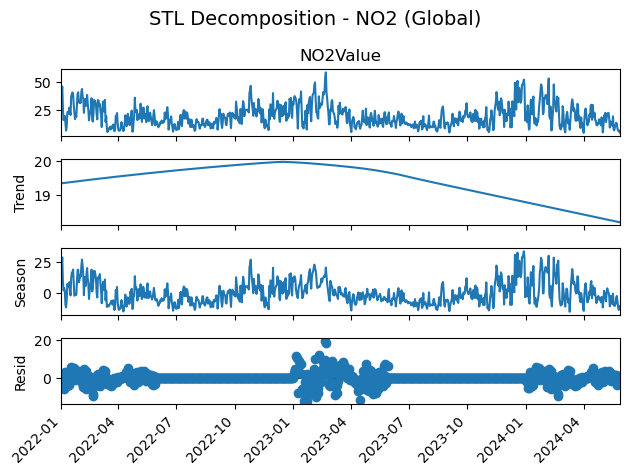

C:\Users\Lucia\AppData\Local\Temp\ipykernel_21068\1879058692.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


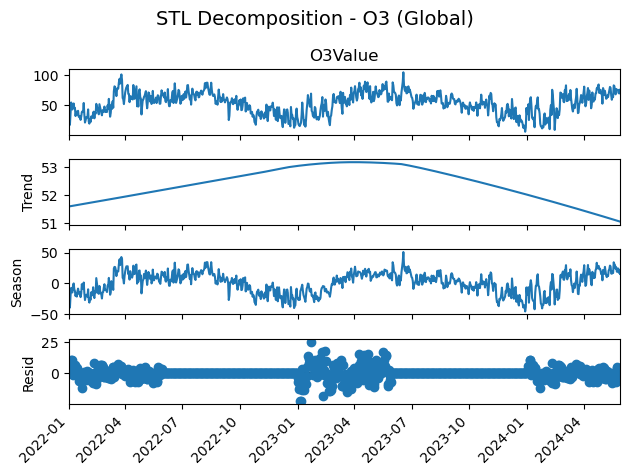

C:\Users\Lucia\AppData\Local\Temp\ipykernel_21068\1879058692.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


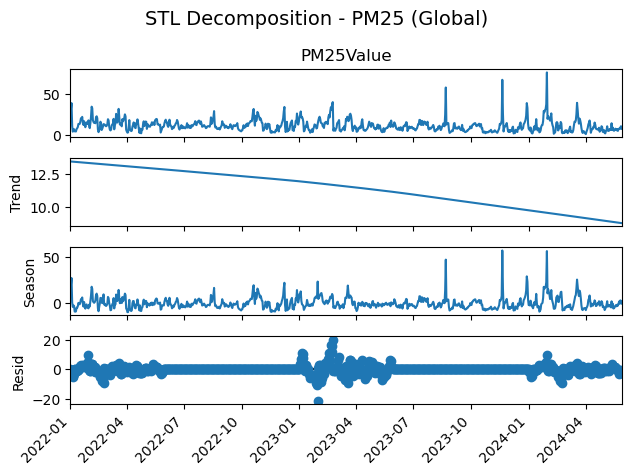

C:\Users\Lucia\AppData\Local\Temp\ipykernel_21068\1879058692.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


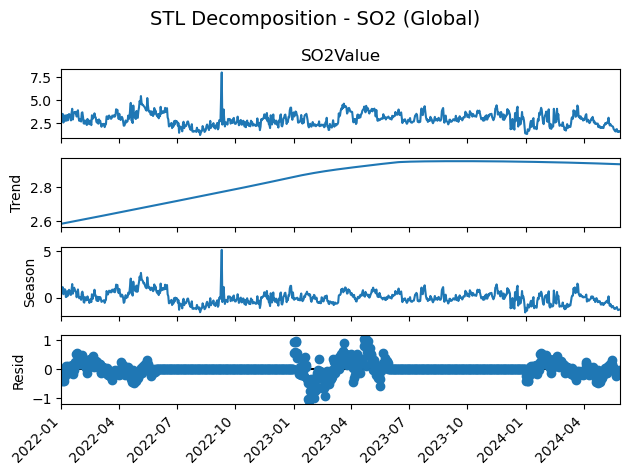

In [8]:
# Análisis global
for contaminante in contaminantes:
    serie_global = datos_d_global[contaminante + 'Value'].dropna()
    analizar_stl_mostrar(serie_global, contaminante, titulo_extra="(Global)")

Los resultados obtenidos muestran patrones diferenciados según el tipo de contaminante:

NO₂: se observa una tendencia ligeramente descendente a lo largo del periodo analizado, lo que podría indicar una mejora gradual de la calidad del aire relacionada con este contaminante. La componente estacional presenta una clara oscilación anual, con concentraciones más elevadas en los meses fríos, coherente con el aumento del tráfico y el uso de calefacción. El componente residual recoge variaciones no explicadas por los anteriores, con ciertos picos que podrían asociarse a eventos puntuales de contaminación.

O₃: la serie presenta una tendencia decreciente más acusada, junto con una estacionalidad muy marcada, caracterizada por valores máximos en los meses de verano. Este comportamiento refleja la naturaleza fotoquímica del ozono troposférico, cuya formación está directamente influenciada por la radiación solar. El componente residual es relativamente estable, lo que indica una buena capacidad del modelo STL para capturar su comportamiento temporal.

PM₂.₅: las partículas en suspensión finas muestran una tendencia relativamente estable, sin grandes oscilaciones, y una estacionalidad menos definida, aunque con cierta recurrencia en picos de invierno y primavera. El componente residual refleja la presencia de episodios atípicos, posiblemente relacionados con intrusiones de polvo o actividad urbana intensa.

SO₂: este contaminante muestra una tendencia levemente creciente, partiendo de niveles bajos. La estacionalidad es muy poco marcada, lo que sugiere que sus fuentes son más irregulares o localizadas, posiblemente industriales. El residuo contiene valores dispersos, lo cual dificulta una interpretación sistemática y sugiere la necesidad de un análisis más localizado.

### Análisis por estación

Para profundizar en la dinámica temporal de los contaminantes atmosféricos seleccionados (NO₂, O₃, PM₂.₅ y SO₂), se aplicó la técnica de descomposición STL (Seasonal-Trend decomposition using Loess) a los datos diarios de cada estación. Esta técnica permite descomponer cada serie temporal en tres componentes principales: tendencia (Trend), estacionalidad (Seasonal) y residuos (Residuals).

Cada gráfico generado ofrece una visualización clara de estos tres elementos para cada combinación estación-contaminante, lo que permite identificar patrones persistentes, fluctuaciones cíclicas y posibles anomalías puntuales.



Estación: A01_AVFRANCIA_10m



C:\Users\Lucia\AppData\Local\Temp\ipykernel_21068\1879058692.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


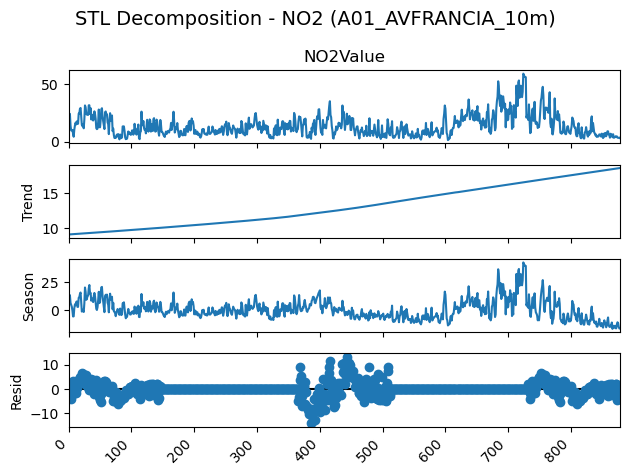

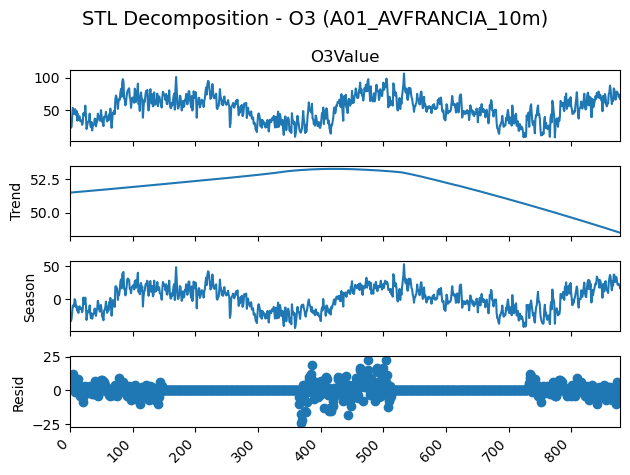

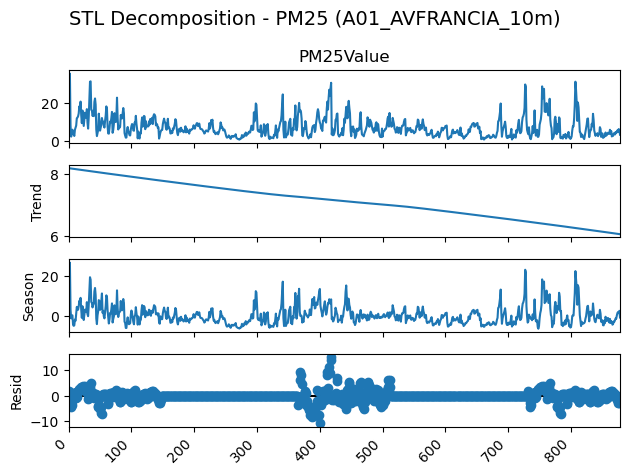

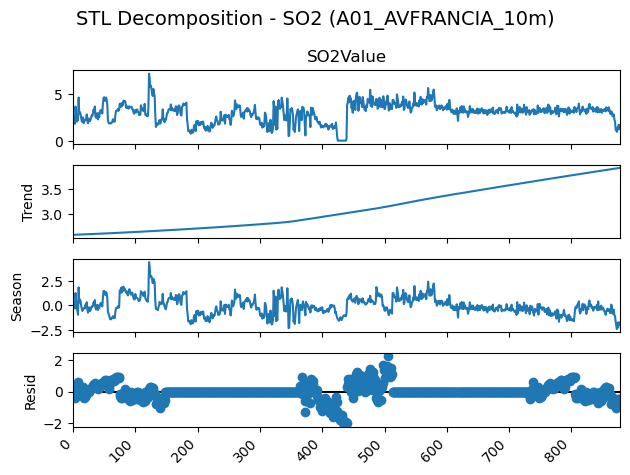


Estación: A02_BULEVARDSUD_10m



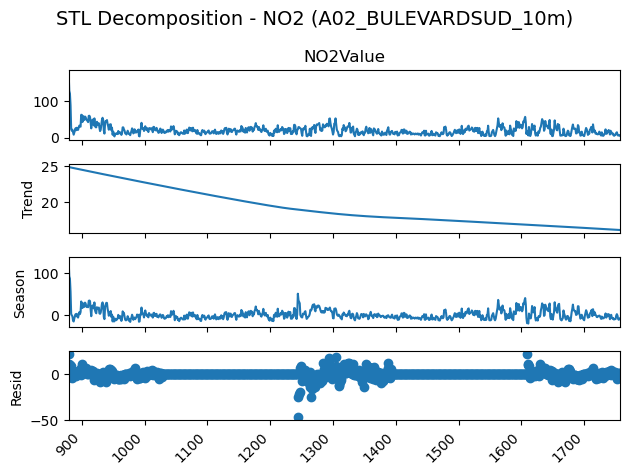

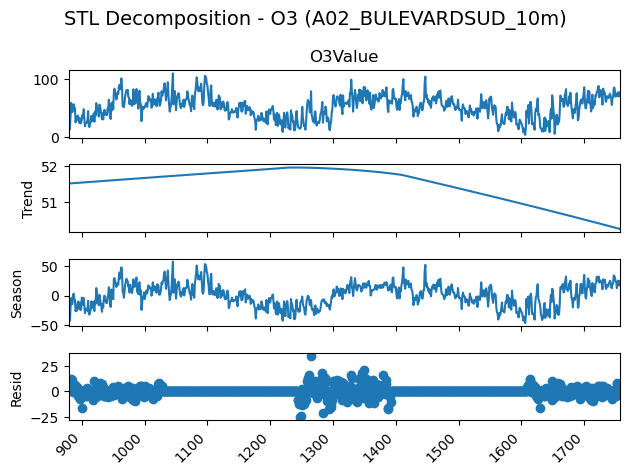

[Aviso] Serie vacía: PM25 (A02_BULEVARDSUD_10m)


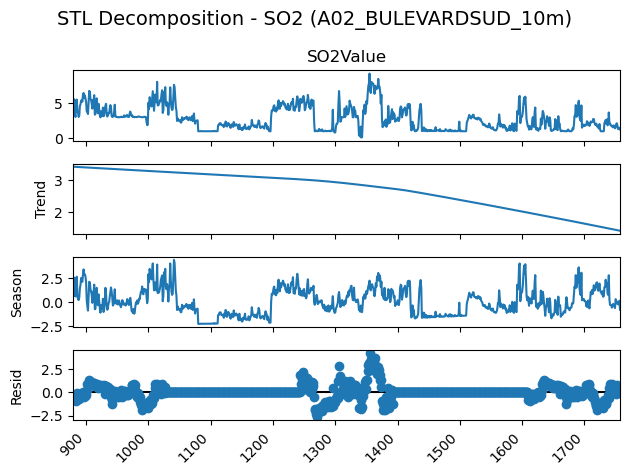


Estación: A03_MOLISOL_10m



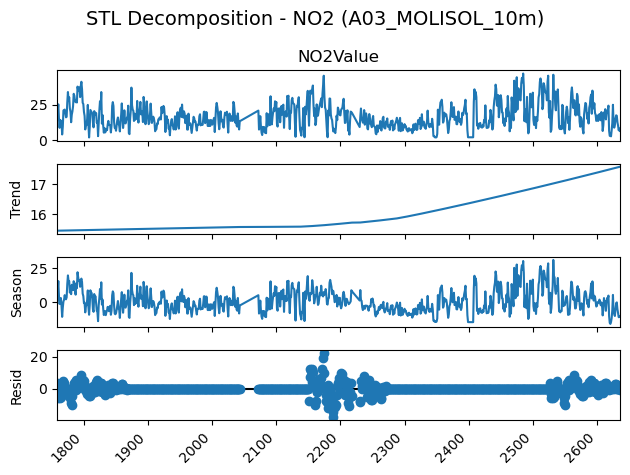

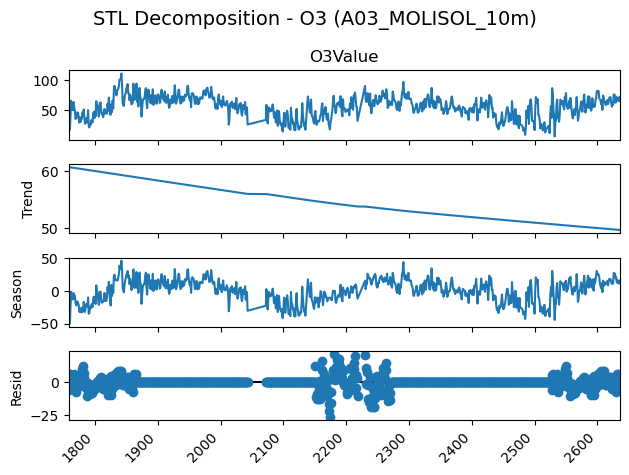

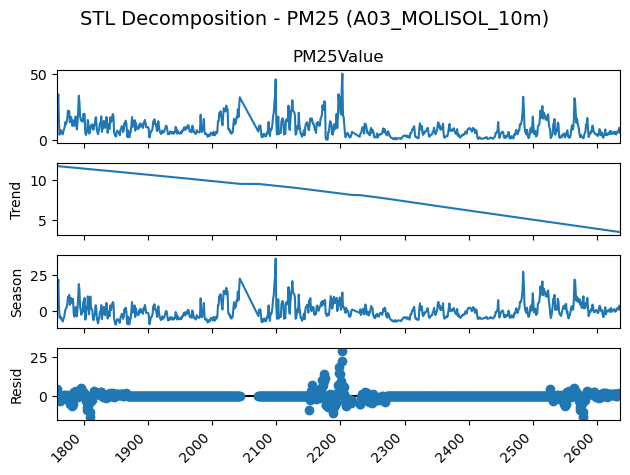

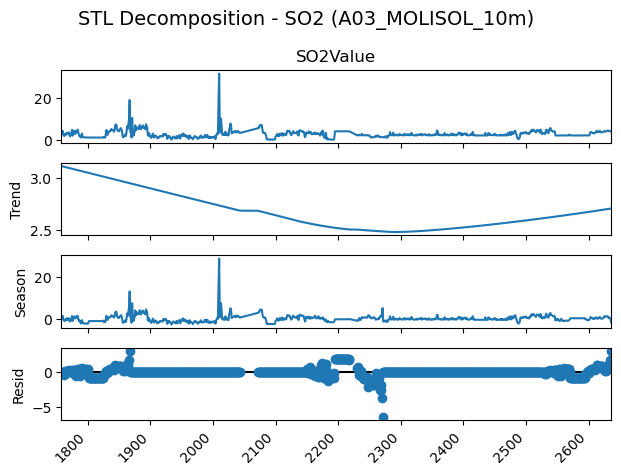


Estación: A04_PISTASILLA_10m



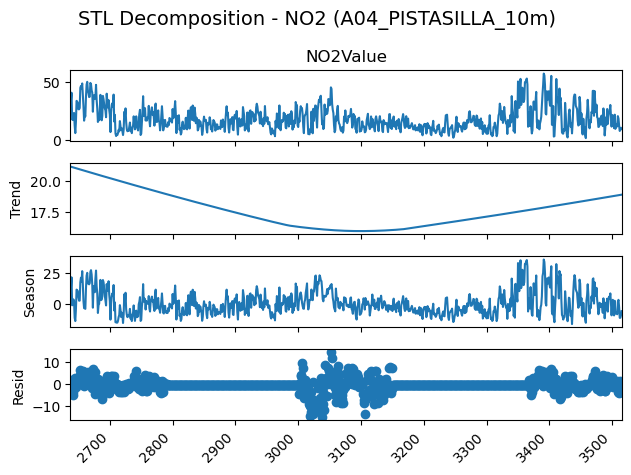

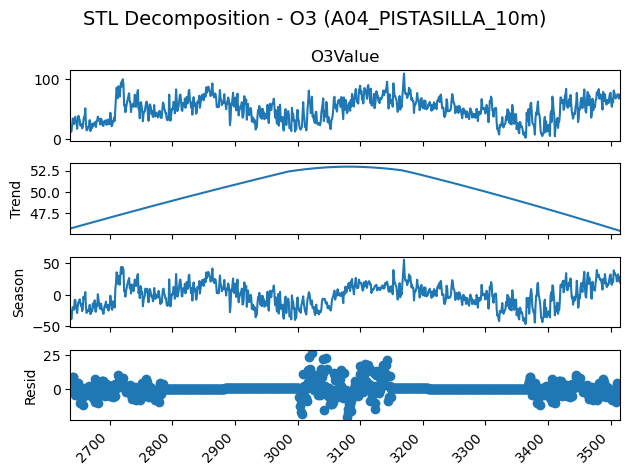

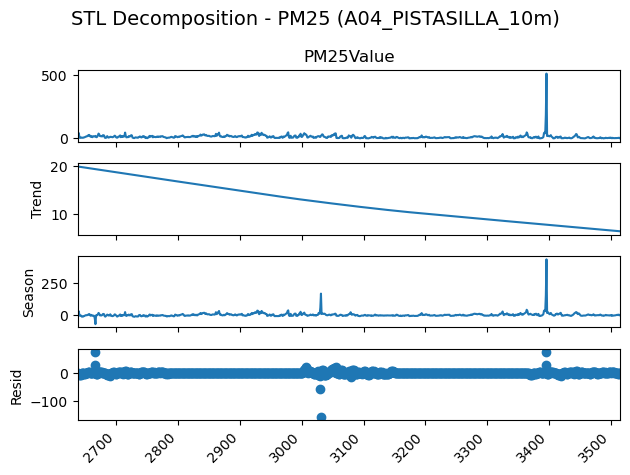

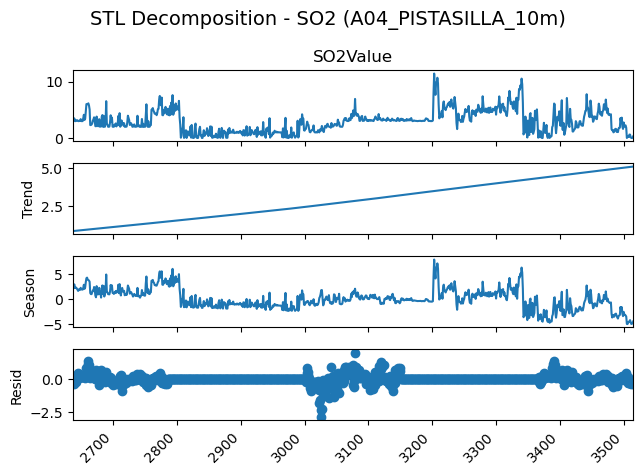


Estación: A05_POLITECNIC_10m



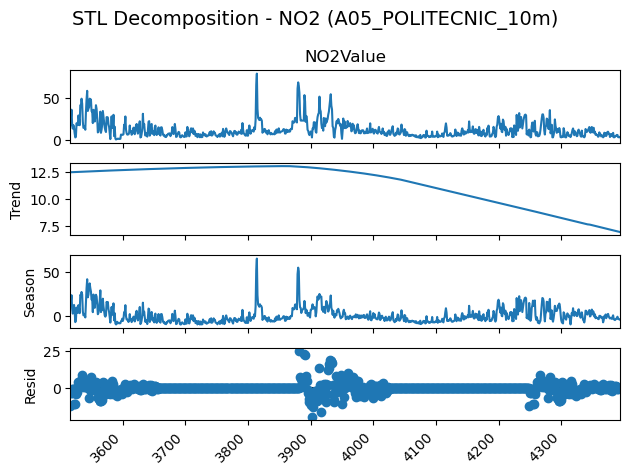

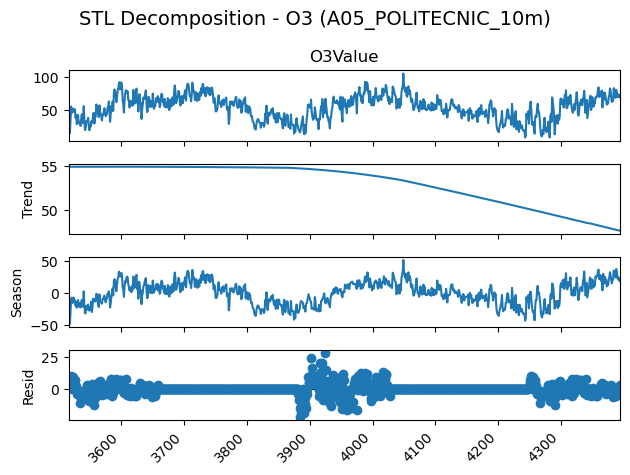

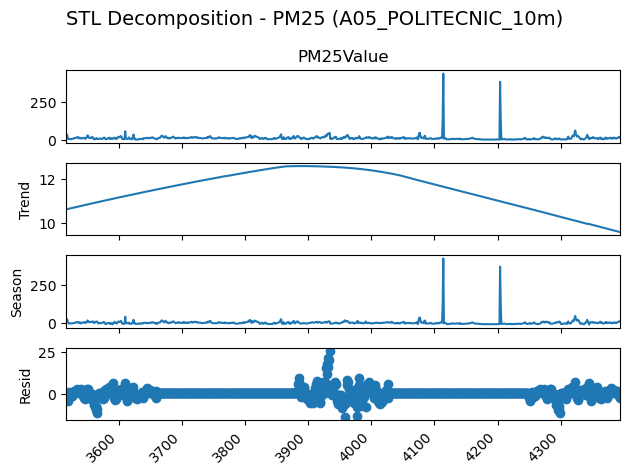

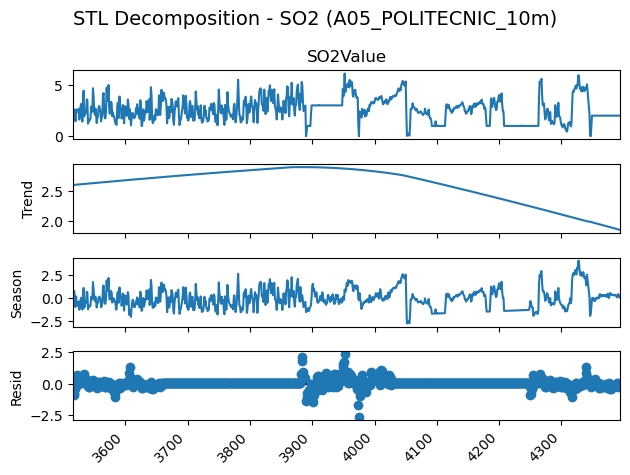


Estación: A06_VIVERS_10m



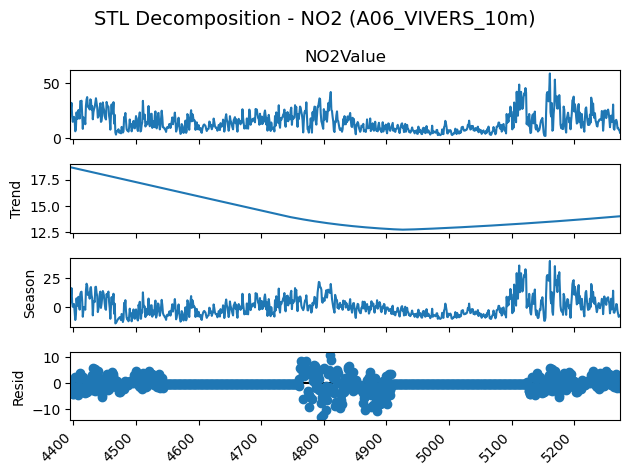

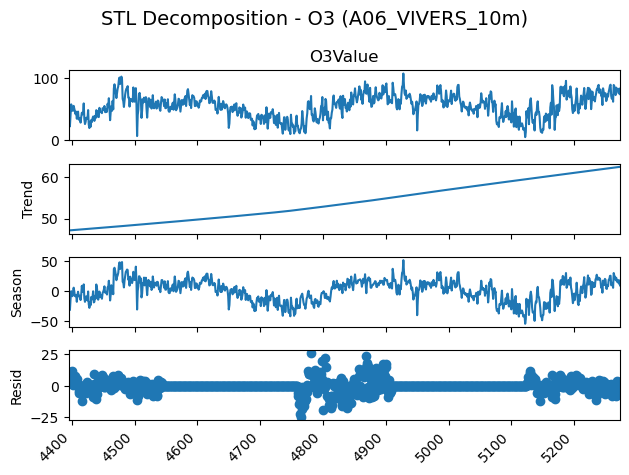

[Aviso] Serie vacía: PM25 (A06_VIVERS_10m)


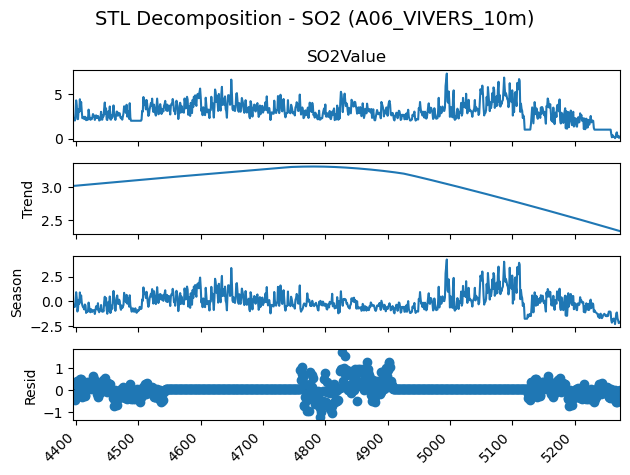


Estación: A07_VALENCIACENTRE_10m



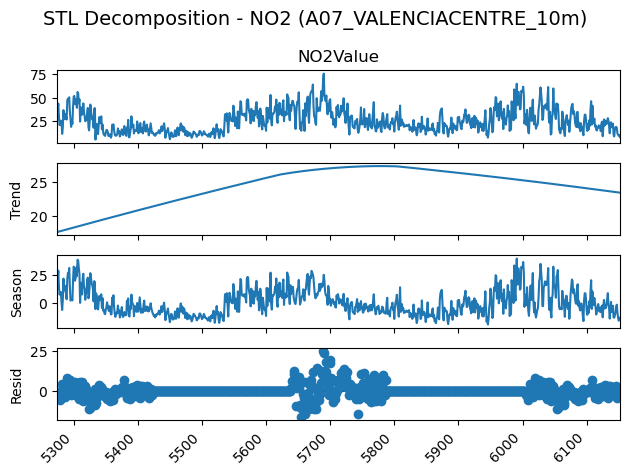

[Aviso] Serie vacía: O3 (A07_VALENCIACENTRE_10m)


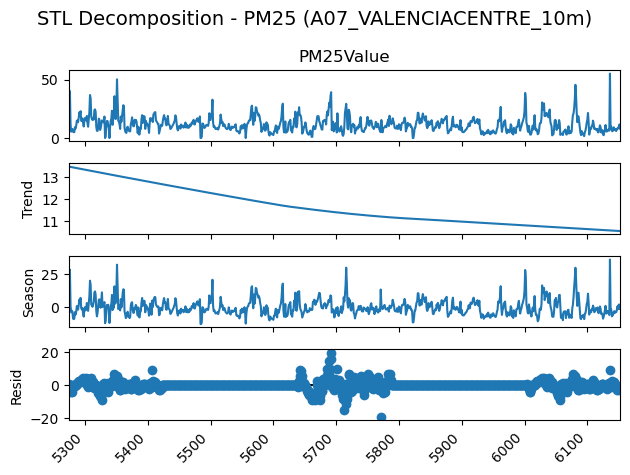

[Aviso] Serie vacía: SO2 (A07_VALENCIACENTRE_10m)

Estación: A08_DR_LLUCH_10m



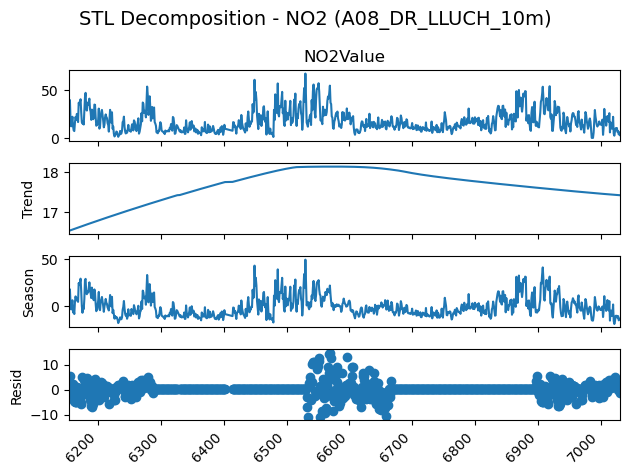

[Aviso] Serie vacía: O3 (A08_DR_LLUCH_10m)


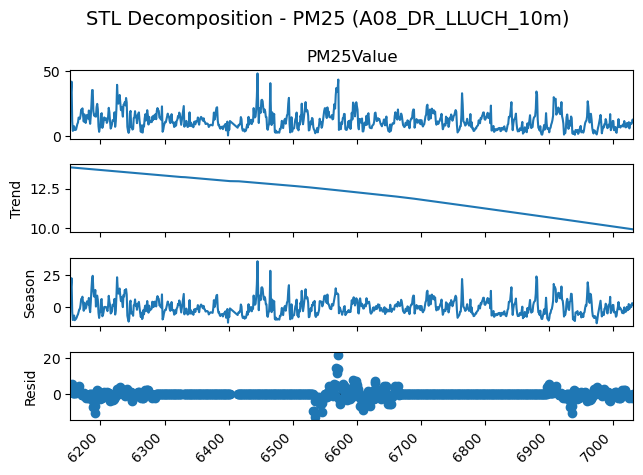

[Aviso] Serie vacía: SO2 (A08_DR_LLUCH_10m)

Estación: A09_CABANYAL_10m



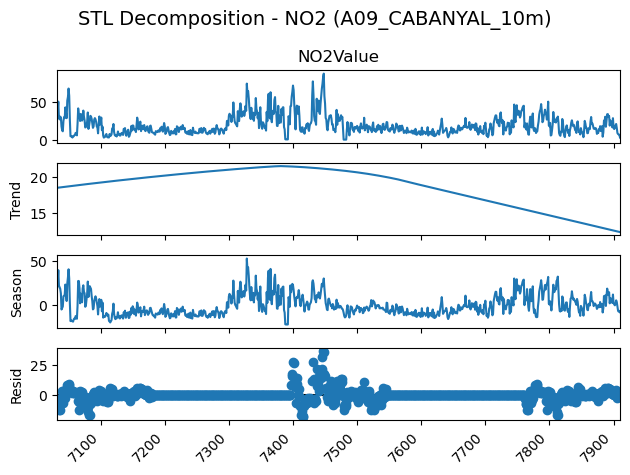

[Aviso] Serie vacía: O3 (A09_CABANYAL_10m)


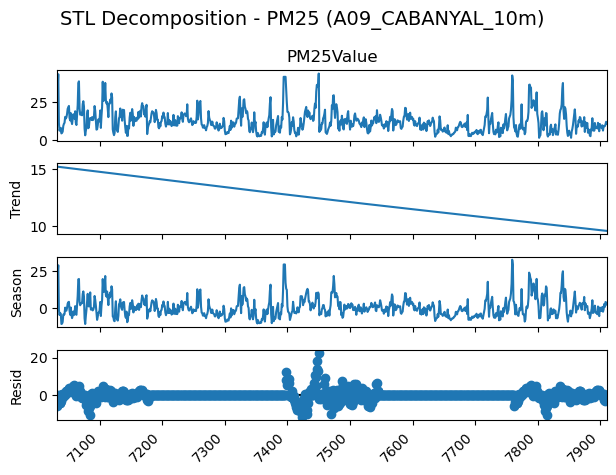

[Aviso] Serie vacía: SO2 (A09_CABANYAL_10m)

Estación: A10_OLIVERETA_10m



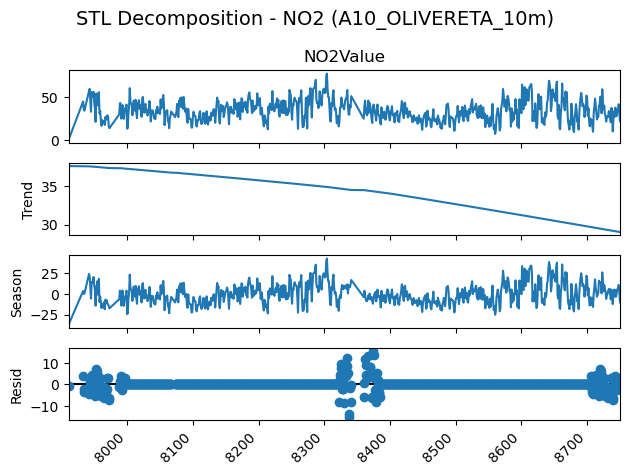

[Aviso] Serie vacía: O3 (A10_OLIVERETA_10m)


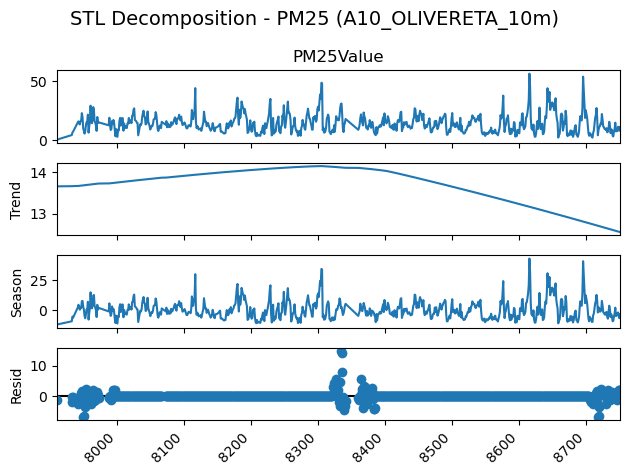

[Aviso] Serie vacía: SO2 (A10_OLIVERETA_10m)

Estación: A11_PATRAIX_10m



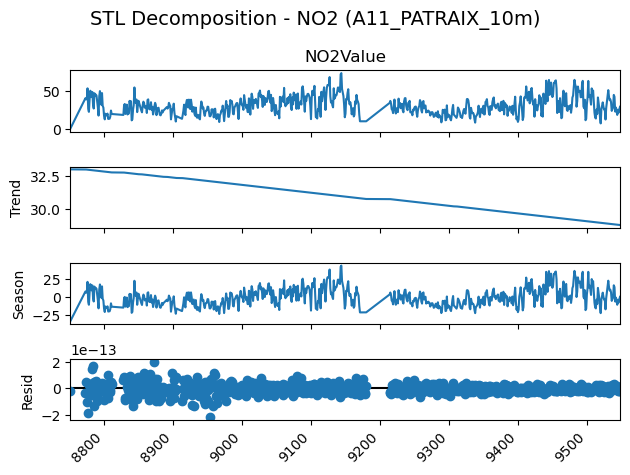

[Aviso] Serie vacía: O3 (A11_PATRAIX_10m)


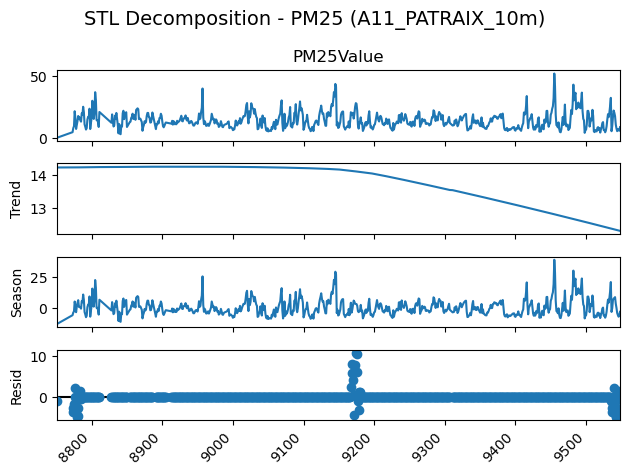

[Aviso] Serie vacía: SO2 (A11_PATRAIX_10m)


In [9]:
for estacion in estaciones:
    print(f"\nEstación: {estacion}\n")
    datos_estacion_stl = datos_d_estacion[datos_d_estacion['entityId'] == estacion]
    for contaminante in contaminantes:
        serie_estacion = datos_estacion_stl[contaminante + 'Value'].dropna()

        analizar_stl_mostrar(serie_estacion, contaminante, titulo_extra=f"({estacion})")

- Tendencia

    En la mayoría de estaciones, la tendencia del NO₂ muestra una ligera disminución progresiva o una estabilización reciente, lo cual puede estar vinculado a políticas de reducción de emisiones vehiculares o cambios en la movilidad urbana.

    Por el contrario, el O₃ presenta una tendencia más ambigua. En algunas estaciones se observa una ligera reducción, pero en otras se mantiene relativamente constante, lo cual podría relacionarse con su formación secundaria y la dependencia de condiciones meteorológicas.

    Para PM₂.₅, varias estaciones (como A03_MOLISOL_10m y A04_PISTASILLA_10m) evidencian una clara disminución en la tendencia a lo largo del tiempo, sugiriendo mejoras en la calidad del aire particulado.

    En el caso del SO₂, donde los valores son relativamente bajos, se observa una tendencia generalmente descendente, indicando posiblemente un menor uso de fuentes emisoras como combustibles fósiles con alto contenido en azufre.

- Estacionalidad

    La componente estacional del O₃ es la más marcada en todas las estaciones con datos disponibles, presentando picos claros durante los meses cálidos (primavera y verano), lo que concuerda con su fotogénesis impulsada por la radiación solar.

    NO₂ y PM₂.₅ también muestran cierta estacionalidad, con valores más altos en los meses fríos, coherente con un aumento del tráfico y de actividades de calefacción.

    El patrón estacional del SO₂ es menos claro en la mayoría de estaciones, aunque en algunas como A02_BULEVARDSUD_10m sí presenta oscilaciones que podrían atribuirse al uso puntual de ciertos combustibles en meses fríos.

- Residuos (ruido o anomalías)

    En todas las series se observan residuos que, si bien están en general dentro de un rango esperable, presentan picos puntuales, que podrían deberse a eventos excepcionales como incendios, obras, episodios de inversión térmica o fenómenos meteorológicos adversos.

    Especial atención merecen estaciones como A04_PISTASILLA_10m (PM₂.₅) o A06_VIVERS_10m (O₃), donde los residuos parecen más pronunciados, lo que sugiere la necesidad de investigar eventos anómalos o errores en la medición.

- Cobertura de datos

    Cabe destacar que la disponibilidad de datos varía entre estaciones y contaminantes. Por ejemplo, O₃ no está disponible en estaciones como A07_VALENCIACENTRE_10m o A11_PATRAIX_10m, lo cual limita la interpretación completa de su comportamiento estacional y tendencia en dichas ubicaciones.